In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette('muted')

# import cenpy as cen
from collections import OrderedDict

import time # to make program sleep temporarily 

import warnings
warnings.simplefilter('ignore')

import re

In [42]:
pres = pd.read_csv('2016President.csv')

# keep select columns
pres_cols = ["county", "office", "party", "candidate", "votes"]
pres = pres[pres_cols]

# keep only where office == President
pres = pres.loc[pres['office'] == "President"]
pres = pres.drop(['office'], axis = 1)

# drop NAN values
pres = pres.dropna()

# get voting sums
agg_functions = {'county': 'first', 'candidate': 'first', 'party': 'first', 'votes': 'sum'}
pres_agg = pres.groupby(['county', 'candidate']).aggregate(agg_functions)

# drop index
pres_agg = pres_agg.reset_index(drop = True).set_axis(["County", "Candidate", "Party", "Votes"], axis = 1)
pres_agg

pres_agg

County        Candidate Party    Votes
0      Albany  Donald J. Trump   REP  47808.0
1      Albany     Gary Johnson   IND   4792.0
2      Albany  Hillary Clinton   DEM  83071.0
3      Albany       Jill Stein   GRN   2475.0
4    Allegany  Donald J. Trump   REP  12525.0
..        ...              ...   ...      ...
247   Wyoming       Jill Stein   GRN    180.0
248     Yates  Donald J. Trump   REP   5660.0
249     Yates     Gary Johnson   IND    494.0
250     Yates  Hillary Clinton   DEM   3659.0
251     Yates       Jill Stein   GRN    146.0

[252 rows x 4 columns]

In [43]:
counties = pres_agg.County.unique().tolist()
# counties
# print(len(counties)) # 63

In [44]:
# get votes per county
votes_per_county = pres_agg.drop(["Candidate", "Party"], axis = 1).groupby("County").sum().reset_index().set_axis(["County", "Votes Per County"], axis = 1)

# add to pres_agg
pres_agg = pres_agg.merge(votes_per_county, on = "County")

In [3]:
# using cenpy get NY data
acs = cen.products.ACS()
acs.from_place('NY')

NameError: name 'cen' is not defined

In [ ]:
# # to see what categories we can look through
# acs.tables

In [ ]:
# all_options = acs.tables.description.unique().tolist()
# all_options 

# # ones to look at 
# # sex
# # race
# # education
# # health insurance
# # family income

#### Create Dataframe on Sex Data

In [ ]:
acs.filter_tables('SEX', by = 'description')

In [ ]:
totalSexData = acs.filter_variables('B01001')

In [ ]:
# sexData = []

# the columns we are looking for
to_keep = ["Estimate!!Total:", "Estimate!!Total:!!Female:",
          "Estimate!!Total:!!Female:!!18 and 19 years", "Estimate!!Total:!!Female:!!20 to 24 years",
          "Estimate!!Total:!!Female:!!25 to 29 years", "Estimate!!Total:!!Female:!!30 to 34 years",
          "Estimate!!Total:!!Female:!!35 to 44 years", "Estimate!!Total:!!Female:!!45 to 54 years",
          "Estimate!!Total:!!Female:!!55 to 64 years", "Estimate!!Total:!!Female:!!65 to 74 years",
          "Estimate!!Total:!!Female:!!75 to 84 years", "Estimate!!Total:!!Female:!!85 years and over",
          "Estimate!!Total:!!Male:",
          "Estimate!!Total:!!Male:!!18 and 19 years", "Estimate!!Total:!!Male:!!20 to 24 years",
          "Estimate!!Total:!!Male:!!25 to 29 years", "Estimate!!Total:!!Male:!!30 to 34 years",
          "Estimate!!Total:!!Male:!!35 to 44 years", "Estimate!!Total:!!Male:!!45 to 54 years",
          "Estimate!!Total:!!Male:!!55 to 64 years", "Estimate!!Total:!!Male:!!65 to 74 years",
          "Estimate!!Total:!!Male:!!75 to 84 years", "Estimate!!Total:!!Male:!!85 years and over"]

# renamed column names
rename = ["Total:", "Total Female:",
          "Total Female: 18 and 19 years", "Total Female: 20 to 24 years",
          "Total Female: 25 to 29 years", "Total Female: 30 to 34 years",
          "Total Female: 35 to 44 years", "Total Female: 45 to 54 years",
          "Total Female: 55 to 64 years", "Total Female: 65 to 74 years",
          "Total Female: 75 to 84 years", "Total Female: 85 years and over",
          "Total Male:",
          "Total Male: 18 and 19 years", "Total Male: 20 to 24 years",
          "Total Male: 25 to 29 years", "Total Male: 30 to 34 years",
          "Total Male: 35 to 44 years", "Total Male: 45 to 54 years",
          "Total Male: 55 to 64 years", "Total Male: 65 to 74 years",
          "Total Male: 75 to 84 years", "Total Male: 85 years and over"]

# do the first 20 counties
for i in range(50, 63, 1):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B01001')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalSexData.index
        labels = totalSexData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # drop the duplciate columns in the county dataframe
    currentDF = currentDF.loc[:, ~currentDF.columns.duplicated()].copy()
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]

    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        sexData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    sexData.append(inner_row)
    
    if (i % 2 == 0):
        print(inner_row)
    
    
    time.sleep(5)
    

In [ ]:
# make into dataframe
sexDF = pd.DataFrame(sexData)

# make first row the header
new_header = sexDF.iloc[0] 
sexDF = sexDF[1:] 
sexDF.columns = new_header 

# view
sexDF

In [ ]:
# write to sex data to csv
# as backup
sexDF.to_csv("NY_sexData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

sexDF = pd.read_csv('NY_sexData.csv')
sexDF = sexDF.drop(['Unnamed: 0'], axis = 1)
sexDF

#### Create Dataframe on Race Data

In [ ]:
acs.filter_tables('RACE', by = 'description')

In [ ]:
totalRaceData = acs.filter_variables('B02001')
totalRaceData["label"].unique().tolist()

In [ ]:
raceData = []

to_keep = ['Estimate!!Total:!!Two or more races:!!Two races including Some other race', 
           "Estimate!!Total:!!Some other race alone", 
           "Estimate!!Total:!!Two or more races:", 
           'Estimate!!Total:!!Two or more races:!!Two races excluding Some other race, and three or more races',
           "Estimate!!Total:!!White alone", "Estimate!!Total:",
           "Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone",
           "Estimate!!Total:!!Asian alone", 
           "Estimate!!Total:!!American Indian and Alaska Native alone",
           "Estimate!!Total:!!Black or African American alone"]

# renamed column names
rename = ["Total: Two or more races: Two races including Some other race", "Total: Some other race alone", 
          "Total: Two or more races", "Total: Two or more races excluding Some other race, and three or more races",
          "Total: White alone", "Total:",
          "Total: Native Hawaiian and Other Pacific Islander alone",
          "Total: Asian alone", "Total: American Indian and Alaska Native alone",
          "Total: Black or African American alone"]


for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B02001')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalRaceData.index
        labels = totalRaceData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # drop the duplciate columns in the dataframe
    currentDF = currentDF.loc[:, ~currentDF.columns.duplicated()].copy()
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]
    

    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        raceData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    raceData.append(inner_row)
    
    # for periodic checking
    if ((i % 2) == 0):
        print(inner_row)
        
        
        
    # force code to take time
    # do this to avoid a 429 error
    # (too many requests error)
    time.sleep(5)    

In [ ]:
# make into dataframe
raceDF = pd.DataFrame(raceData)

# add header
new_header = raceDF.iloc[0] 
raceDF = raceDF[1:] 
raceDF.columns = new_header 

# view
raceDF

In [ ]:
# write to csv
# write to sex data to csv
# as backup
raceDF.to_csv("NY_raceData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

raceDF = pd.read_csv('NY_raceData.csv')
raceDF = raceDF.drop(['Unnamed: 0'], axis = 1)
raceDF

## Create Dataframe on Education

In [ ]:
acs.filter_tables('EDUCATION', by = 'description')

In [ ]:
totalEducationData = acs.filter_variables('B15002')
totalEducationData

In [ ]:
educationData = []

# the columns we are looking for
to_keep = ["Estimate!!Total:!!Male:", "Estimate!!Total:!!Male:!!Associate's degree", 
           "Estimate!!Total:!!Male:!!Some college, 1 or more years, no degree",
           "Estimate!!Total:!!Male:!!Master's degree",
           "Estimate!!Total:!!Male:!!Bachelor's degree",
           "Estimate!!Total:!!Male:!!Doctorate degree",
           "Estimate!!Total:!!Male:!!Professional school degree",
           "Estimate!!Total:!!Male:!!12th grade, no diploma",
           "Estimate!!Total:!!Male:!!High school graduate (includes equivalency)",
           "Estimate!!Total:!!Female:",
           "Estimate!!Total:!!Female:!!Associate's degree", 
           "Estimate!!Total:!!Female:!!Some college, 1 or more years, no degree",
           "Estimate!!Total:!!Female:!!Master's degree",
           "Estimate!!Total:!!Female:!!Bachelor's degree",
           "Estimate!!Total:!!Female:!!Doctorate degree",
           "Estimate!!Total:!!Female:!!Professional school degree",
           "Estimate!!Total:!!Female:!!12th grade, no diploma",
           "Estimate!!Total:!!Female:!!High school graduate (includes equivalency)"]

# renamed column names
rename = ["Total: Male:",
           "Total: Male: Associate's degree", 
           "Total: Male: Some college, 1 or more years, no degree",
           "Total: Male: Master's degree",
           "Total: Male: Bachelor's degree",
           "Total: Male: Doctorate degree",
           "Total: Male: Professional school degree",
           "Total: Male: 12th grade, no diploma",
           "Total: Male: High school graduate (includes equivalency)",
           "Total: Female:",
           "Total: Female: Associate's degree", 
           "Total: Female: Some college, 1 or more years, no degree",
           "Total: Female: Master's degree",
           "Total: Female: Bachelor's degree",
           "Total: Female: Doctorate degree",
           "Total: Female: Professional school degree",
           "Total: Female: 12th grade, no diploma",
           "Total: Female: High school graduate (includes equivalency)"]

for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B15002')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalEducationData.index
        labels = totalEducationData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # drop the duplciate columns in the county dataframe
    currentDF = currentDF.loc[:, ~currentDF.columns.duplicated()].copy()
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]
    
    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        educationData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    educationData.append(inner_row)
    

    # for periodic checking
    if ((i % 2) == 0):
        print(inner_row)
        
        
        
    # force code to take time
    # do this to avoid a 429 error
    # (too many requests error)
    time.sleep(5)    

    

In [ ]:
# make into dataframe
educationDF = pd.DataFrame(educationData)

# add header
new_header = educationDF.iloc[0] 
educationDF = educationDF[1:] 
educationDF.columns = new_header 

# view
educationDF

In [ ]:
# write to csv
# write to sex data to csv
# as backup
educationDF.to_csv("NY_educationData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

educationDF = pd.read_csv('NY_educationData.csv')
educationDF = educationDF.drop(['Unnamed: 0'], axis = 1)
educationDF

#### Create Dataframe on Health Insurance

In [ ]:
acs.filter_tables('HEALTH INSURANCE', by = 'description')

In [ ]:
totalHealthData = acs.filter_variables('B27001')
totalHealthData

In [ ]:
healthData = []

# the columns we want to keep
to_keep = ['Estimate!!Total:',
           'Estimate!!Total:!!Male:',
           'Estimate!!Total:!!Male:!!19 to 25 years:',
           'Estimate!!Total:!!Male:!!19 to 25 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!19 to 25 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!26 to 34 years:',
           'Estimate!!Total:!!Male:!!26 to 34 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!26 to 34 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!35 to 44 years:',
           'Estimate!!Total:!!Male:!!35 to 44 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!35 to 44 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!45 to 54 years:',    
           'Estimate!!Total:!!Male:!!45 to 54 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!45 to 54 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!55 to 64 years:',           
           'Estimate!!Total:!!Male:!!55 to 64 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!55 to 64 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!65 to 74 years:',
           'Estimate!!Total:!!Male:!!65 to 74 years:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!65 to 74 years:!!No health insurance coverage',
           'Estimate!!Total:!!Male:!!75 years and over:',
           'Estimate!!Total:!!Male:!!75 years and over:!!With health insurance coverage',
           'Estimate!!Total:!!Male:!!75 years and over:!!No health insurance coverage',
           'Estimate!!Total:!!Female:',
           'Estimate!!Total:!!Female:!!19 to 25 years:',
           'Estimate!!Total:!!Female:!!19 to 25 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!19 to 25 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!26 to 34 years:',
           'Estimate!!Total:!!Female:!!26 to 34 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!26 to 34 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!35 to 44 years:',
           'Estimate!!Total:!!Female:!!35 to 44 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!35 to 44 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!45 to 54 years:',    
           'Estimate!!Total:!!Female:!!45 to 54 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!45 to 54 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!55 to 64 years:',           
           'Estimate!!Total:!!Female:!!55 to 64 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!55 to 64 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!65 to 74 years:',
           'Estimate!!Total:!!Female:!!65 to 74 years:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!65 to 74 years:!!No health insurance coverage',
           'Estimate!!Total:!!Female:!!75 years and over:',
           'Estimate!!Total:!!Female:!!75 years and over:!!With health insurance coverage',
           'Estimate!!Total:!!Female:!!75 years and over:!!No health insurance coverage']


# renamed column names
rename = ['Total:',
          'Total: Male:',
          'Total: Male: 19 to 25 years:',
          'Total: Male: 19 to 25 years: With health insurance coverage',
          'Total: Male: 19 to 25 years: No health insurance coverage',
          'Total: Male: 26 to 34 years:',
          'Total: Male: 26 to 34 years: With health insurance coverage',
          'Total: Male: 26 to 34 years: No health insurance coverage',
          'Total: Male: 35 to 44 years:',
          'Total: Male: 35 to 44 years: With health insurance coverage',
          'Total: Male: 35 to 44 years: No health insurance coverage',
          'Total: Male: 45 to 54 years:',
          'Total: Male: 45 to 54 years: With health insurance coverage',
          'Total: Male: 45 to 54 years: No health insurance coverage',
          'Total: Male: 55 to 64 years:',
          'Total: Male: 55 to 64 years: With health insurance coverage',
          'Total: Male: 55 to 64 years: No health insurance coverage',
          'Total: Male: 65 to 74 years:',
          'Total: Male: 65 to 74 years: With health insurance coverage',
          'Total: Male: 65 to 74 years: No health insurance coverage',
          'Total: Male: 75 years and over:',
          'Total: Male: 75 years and over: With health insurance coverage',
          'Total: Male: 75 years and over: No health insurance coverage',
          'Total: Female:',
          'Total: Female: 19 to 25 years:',
          'Total: Female: 19 to 25 years: With health insurance coverage',
          'Total: Female: 19 to 25 years: No health insurance coverage',
          'Total: Female: 26 to 34 years:',
          'Total: Female: 26 to 34 years: With health insurance coverage',
          'Total: Female: 26 to 34 years: No health insurance coverage',
          'Total: Female: 35 to 44 years:',
          'Total: Female: 35 to 44 years: With health insurance coverage',
          'Total: Female: 35 to 44 years: No health insurance coverage',
          'Total: Female: 45 to 54 years:',
          'Total: Female: 45 to 54 years: With health insurance coverage',
          'Total: Female: 45 to 54 years: No health insurance coverage',
          'Total: Female: 55 to 64 years:',
          'Total: Female: 55 to 64 years: With health insurance coverage',
          'Total: Female: 55 to 64 years: No health insurance coverage',
          'Total: Female: 65 to 74 years:',
          'Total: Female: 65 to 74 years: With health insurance coverage',
          'Total: Female: 65 to 74 years: No health insurance coverage',
          'Total: Female: 75 years and over:',
          'Total: Female: 75 years and over: With health insurance coverage',
          'Total: Female: 75 years and over: No health insurance coverage']

# run in groups of 10 because of 'too many requests' error

for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B27001')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalHealthData.index
        labels = totalHealthData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
        
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]

    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        healthData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    healthData.append(inner_row)
    

    # for periodic checking
    if ((i % 2) == 0):
        print(inner_row)
        
        
        
    # force code to take time
    # do this to avoid a 429 error
    # (too many requests error)
    time.sleep(5)    

    

In [ ]:
# make into dataframe
healthDF = pd.DataFrame(healthData)

# add header
new_header = healthDF.iloc[0] 
healthDF = healthDF[1:] 
healthDF.columns = new_header 

# view
healthDF

In [ ]:
# write to csv
# write to sex data to csv
# as backup
healthDF.to_csv("NY_healthData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

healthDF = pd.read_csv('NY_healthData.csv')
healthDF = healthDF.drop(['Unnamed: 0'], axis = 1)
healthDF

#### Create Dataframe on Income

In [ ]:
acs.filter_tables('MEDIAN INCOME', by = 'description')

In [ ]:
totalIncomeData = acs.filter_variables('B19326')
totalIncomeData

In [ ]:
incomeData = []

# columns to keep
to_keep = ['Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Male --!!Total (dollars)',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Male --!!Total (dollars)!!Worked full-time, year-round in the past 12 months (dollars)',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Male --!!Total (dollars)!!Other (dollars)',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Female --!!Total (dollars)',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Female --!!Total (dollars)!!Worked full-time, year-round in the past 12 months (dollars)',
           'Estimate!!Median income in the past 12 months (in 2019 inflation-adjusted dollars) --!!Total (dollars):!!Female --!!Total (dollars)!!Other (dollars)']

# renamed column names
rename = ['Total (dollars):',
          'Total Male (dollars):',
          'Total Male: Full-Time, Year-Round (dollars)',
          'Total Male: Other (dollars)',
          'Total Female (dollars):',
          'Total Female: Full-Time, Year-Round (dollars)',
          'Total Female: Other (dollars)']


for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B19326')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalIncomeData.index
        labels = totalIncomeData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
        
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]
    
    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        incomeData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    incomeData.append(inner_row)
    

    # for periodic checking
    if ((i % 2) == 0):
        print(inner_row)
        
        
        
    # force code to take time
    # do this to avoid a 429 error
    # (too many requests error)
    time.sleep(5)    

In [ ]:
# make into dataframe
incomeDF = pd.DataFrame(incomeData)

# add header
new_header = incomeDF.iloc[0] 
incomeDF = incomeDF[1:] 
incomeDF.columns = new_header 

# view
incomeDF

In [ ]:
# write to csv
# write to sex data to csv
# as backup
incomeDF.to_csv("NY_incomeData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

incomeDF = pd.read_csv('NY_incomeData.csv')
incomeDF = incomeDF.drop(['Unnamed: 0'], axis = 1)
incomeDF

#### Create Dataframe on Housing

In [ ]:
acs.filter_tables('HOUSE', by = 'description')

In [ ]:
totalHousingData = acs.filter_variables('B11012')
# totalHousingData

In [ ]:
housingData = []

# columns to drop
to_drop = ['GEOID', 'geometry', 'state', 'county', 'tract', "NAME"]


to_keep = ['Estimate!!Total:',
           'Estimate!!Total:!!Female householder, no spouse or partner present:', 
           'Estimate!!Total:!!Female householder, no spouse or partner present:!!Living alone',
           'Estimate!!Total:!!Female householder, no spouse or partner present:!!With only nonrelatives present',
           'Estimate!!Total:!!Female householder, no spouse or partner present:!!With own children under 18 years',
           'Estimate!!Total:!!Female householder, no spouse or partner present:!!With relatives, no own children under 18 years',
           'Estimate!!Total:!!Male householder, no spouse or partner present:',
           'Estimate!!Total:!!Male householder, no spouse or partner present:!!Living alone',
           'Estimate!!Total:!!Male householder, no spouse or partner present:!!With only nonrelatives present',
           'Estimate!!Total:!!Male householder, no spouse or partner present:!!With own children under 18 years',
           'Estimate!!Total:!!Male householder, no spouse or partner present:!!With relatives, no own children under 18 years',
           'Estimate!!Total:!!Married-couple household:',
           'Estimate!!Total:!!Married-couple household:!!With own children under 18 years',
           'Estimate!!Total:!!Married-couple household:!!With no own children under 18 years',
           'Estimate!!Total:!!Cohabiting couple household:',
           'Estimate!!Total:!!Cohabiting couple household:!!With own children of the householder under 18 years',
           'Estimate!!Total:!!Cohabiting couple household:!!With no own children of the householder under 18 years']

# renamed column names
rename = ['Total:',
          'Total: Female householder, no spouse or partner present:',
          'Total: Female householder, no spouse or partner present: Living alone',
          'Total: Female householder, no spouse or partner present: With only nonrelatives present',
          'Total: Female householder, no spouse or partner present: With own children under 18 years',
          'Total: Female householder, no spouse or partner present: With relatives, no own children under 18 years',
          'Total: Male householder, no spouse or partner present:',
          'Total: Male householder, no spouse or partner present: Living alone',
          'Total: Male householder, no spouse or partner present: With only nonrelatives present',
          'Total: Male householder, no spouse or partner present: With own children under 18 years',
          'Total: Male householder, no spouse or partner present: With relatives, no own children under 18 years',
          'Total: Married-couple household:',
          'Total: Married-couple household: With own children under 18 years',
          'Total: Married-couple household: With no own children under 18 years',
          'Total: Cohabiting couple household:',
          'Total: Cohabiting couple household: With own children of the householder under 18 years',
          'Total: Cohabiting couple household: With no own children of the householder under 18 years']


for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name, variables = 'B11012')
    current = counties[i]
    
    # if first round through
    # create labels to rename the dataframes
    if i == 0:
        indexVals = totalHousingData.index
        labels = totalHousingData['label'].to_list()
        labelsDict = OrderedDict({})
        for key in indexVals:
            for value in labels:
                labelsDict[key] = value
                labels.remove(value)
                break

        labelsDict.update({"geometry": "geometry"})
        labelsDict.move_to_end("geometry", last = False)

        labelsDict.update({"GEOID": "GEOID"})
        labelsDict.move_to_end("GEOID", last = False)

        labelsDict.update({"state": "state"})
        labelsDict.update({"county": "county"})
        labelsDict.update({"tract": "tract"})
        labelsDict.update({"NAME": "NAME"})
        
    
    # rename the dataframe
    currentDF.columns = currentDF.columns.to_series().map(labelsDict)
    
    # only keep the previously selected columns
    currentDF = currentDF[to_keep]
    
    # rename the columns 
    currentDF = currentDF.set_axis(rename, axis = 1)
    
    
    # get the sums for each category and put into a dictonary
    current_sums = currentDF.sum().to_dict()
    current_sums = OrderedDict(current_sums)

    current_sums.update({"County": current})
    current_sums.move_to_end("County", last = False)

    current_sums = dict(current_sums)

    # if first run through
    # get the headers for the final dataframe
    # append to the final dataframe
    if i == 0:
        headers = list(current_sums.keys())
        housingData.append(headers)
        
    # create inner_row to append
    # and append to final dataframe
    inner_row = list(current_sums.values())
    housingData.append(inner_row)
    

    # for periodic checking
    if ((i % 2) == 0):
        print(inner_row)
        
        
        
    # force code to take time
    # do this to avoid a 429 error
    # (too many requests error)
    time.sleep(5)    

In [ ]:
# make into dataframe
housingDF = pd.DataFrame(housingData)

# add header
new_header = housingDF.iloc[0] 
housingDF = housingDF[1:] 
housingDF.columns = new_header 

# view
housingDF

In [ ]:
# write to csv
# write to sex data to csv
# as backup
housingDF.to_csv("NY_housingData.csv")

In [ ]:
# check csv saved correctly
# read data in from csv
# this is so you don't have to run through the previous for loop (saves time)

housingDF = pd.read_csv('NY_housingData.csv')
housingDF = housingDF.drop(['Unnamed: 0'], axis = 1)
housingDF

#### Get GeoData for NY Counties

In [ ]:
geoData = []
header = ["county", "geometry"]
geoData.append(header)

for i in range(len(counties)):

    name = counties[i] + ", NY"
    currentDF = acs.from_county(name)
    current = counties[i]
    

    geometries = currentDF["geometry"].tolist()
    
    isMulti = False
    for j in range(len(geometries)):
        if geometries[j].geom_type == "MultiPolygon":
            isMulti = True
            index = j
            break
    
    if isMulti:
        merged = geometries[j]
    else:
        merged = sg.MultiPolygon(geometries)
    
    inner = [current, merged]
    
    geoData.append(inner)
    
    print(inner)
    
    time.sleep(5)

In [ ]:
geoDataDF = pd.DataFrame(geoData)

new_header = geoDataDF.iloc[0] #grab the first row for the header
geoDataDF = geoDataDF[1:] #take the data less the header row
geoDataDF.columns = new_header #set the header row as the df header

geoDataDF

In [ ]:
geoDataDF.to_csv("NY_geoData.csv")

In [ ]:
geoDataDF











# Exploratory Analysis

In [45]:
# load in all data
# excluding president (already loaded)

# sex and age
sexDF = pd.read_csv('NY_sexData.csv')
sexDF = sexDF.drop(['Unnamed: 0'], axis = 1)

# race
raceDF = pd.read_csv('NY_raceData.csv')
raceDF = raceDF.drop(['Unnamed: 0'], axis = 1)

#education
educationDF = pd.read_csv('NY_educationData.csv')
educationDF = educationDF.drop(['Unnamed: 0'], axis = 1)

# health insurance 
healthDF = pd.read_csv('NY_healthData.csv')
healthDF = healthDF.drop(['Unnamed: 0'], axis = 1)

# income
incomeDF = pd.read_csv('NY_incomeData.csv')
incomeDF = incomeDF.drop(['Unnamed: 0'], axis = 1)

# housing
housingDF = pd.read_csv('NY_housingData.csv')
housingDF = housingDF.drop(['Unnamed: 0'], axis = 1)

# geoData
geoDataDF = pd.read_csv("NY_geoData.csv")
geoDataDF = geoDataDF.drop(['Unnamed: 0'], axis = 1)
geoDataDF = geoDataDF.set_axis(["County", "geometry"], axis = 1)

## Data Cleaning and Remove Outliers

### President

In [4]:
# remove outliers
Q1 = pres_agg["Votes"].quantile(.25)
Q3 = pres_agg["Votes"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
 
upper_array = np.where(pres_agg["Votes"] >= upper)[0]
lower_array = np.where(pres_agg["Votes"] <= lower)[0]

# remove
pres_agg.drop(index = upper_array, inplace = True)
pres_agg.drop(index = lower_array, inplace = True)

# create set of outliers
outliers = list(lower_array)
for i in list(upper_array):
    outliers.append(i)
    
outliers_set = set(outliers)

Text(0.5, 1.0, 'Count of Votes for Each Candidate')

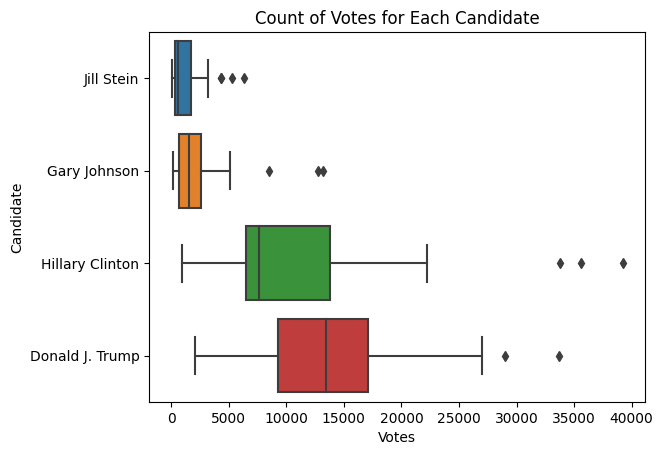

In [88]:
# box plot to visualize voting data
pres_plot = sns.boxplot(pres_agg, x = "Votes", y = "Candidate")
pres_plot.set_title("Count of Votes for Each Candidate")

### Sex and Age

In [7]:
# first want to only keep county, and age ranges and rename
sex_ranges = sexDF.drop(["Total:", "Total Female:", "Total Male:"], axis = 1)

# remove total
cols = list(sex_ranges.columns.values)

new_ranges = []
header = ["County", "Age Range", "Sum"]

for i in range(len(sex_ranges["County"])):
    
    county = sex_ranges["County"][i]

    for j in range(len(cols)):
        
        if "County" not in cols[j]:
        
            txt = cols[j].split(": ")

            title = txt[1]

            cur_sum = sex_ranges[cols[j]][i]

            if len(new_ranges) != 0:
                for k in new_ranges:

                    if title in k:
                        k[2] = cur_sum + k[2]

                    else:
                        inner = [county, title, cur_sum]

                        new_ranges.append(inner)
                        break
            else:
                inner = [county, title, cur_sum]
                new_ranges.append(inner)


                
                
rangesDF = pd.DataFrame(new_ranges)
rangesDF = rangesDF.set_axis(header, axis = 1)

In [8]:
# get and remove outliers

Q1 = rangesDF["Sum"].quantile(.25)
Q3 = rangesDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(rangesDF["Sum"] >= upper)[0]
lower_array = np.where(rangesDF["Sum"] <= lower)[0]

# remove
rangesDF.drop(index = upper_array, inplace = True)
rangesDF.drop(index = lower_array, inplace = True)


# create set of outliers
ranges_outliers = list(lower_array)
for i in list(upper_array):
    ranges_outliers.append(i)
    
for i in list(ranges_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Age Ranges by Population')

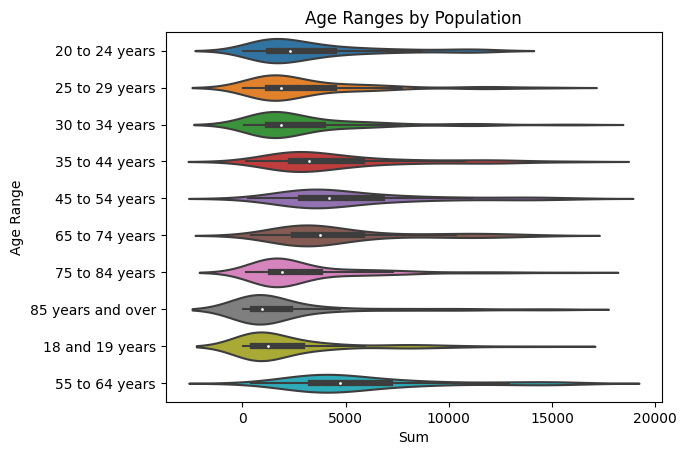

In [86]:
# box plot to visualize age ranges 
age_plot = sns.violinplot(rangesDF, x = "Sum", y = "Age Range")
age_plot.set_title("Age Ranges by Population")

## Race

In [11]:
# first want to only keep county, and age ranges and rename
raceSep = raceDF.drop(["Total:"], axis = 1)


# remake dataframe so each county all columns containg race become
# a datapoint with matching county and sum

cols = list(raceSep.columns.values)

new_races = []
header = ["County", "Race", "Sum"]

for i in range(len(raceSep["County"])):
    
    county = raceSep["County"][i]

    for j in range(len(cols)):
        
        if "County" not in cols[j]:
        
            txt = cols[j].split(": ")

            title = txt[1]

            cur_sum = raceSep[cols[j]][i]

            if len(new_races) != 0:
                for k in new_races:

                    if title in k:
                        k[2] = cur_sum + k[2]

                    else:
                        inner = [county, title, cur_sum]

                        new_races.append(inner)
                        break
            else:
                inner = [county, title, cur_sum]
                new_races.append(inner)


                
                
raceSepDF = pd.DataFrame(new_races)
raceSepDF = raceSepDF.set_axis(header, axis = 1)

In [12]:
# get and remove outliers

Q1 = raceSepDF["Sum"].quantile(.25)
Q3 = raceSepDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(raceSepDF["Sum"] >= upper)[0]
lower_array = np.where(raceSepDF["Sum"] <= lower)[0]

# remove
raceSepDF.drop(index = upper_array, inplace = True)
raceSepDF.drop(index = lower_array, inplace = True)


# create set of outliers
race_outliers = list(lower_array)
for i in list(upper_array):
    race_outliers.append(i)
    
for i in list(race_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Race Distribution by Population')

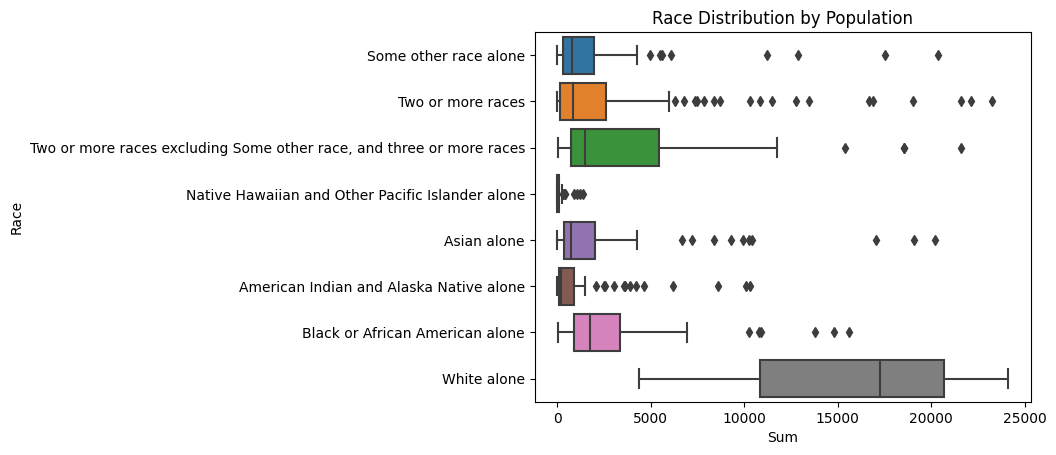

In [85]:
# box plot to visualize race distributions
race_plot = sns.boxplot(raceSepDF, x = "Sum", y = "Race")
race_plot.set_title("Race Distribution by Population")

## Education

In [21]:
# drop total male and total female
eduSep = educationDF.drop(["Total: Male:", "Total: Female:"], axis = 1)


columns = list(eduSep.columns.values)
headers = ["County", "Education Level", "Gender", "Sum"]

edu_fac = []

for i in range(len(eduSep["County"])):
    
    for j in range(len(columns)):
        
        county = eduSep["County"][i]
        
        
        if "Male:" in columns[j]:
            txt = columns[j]
            sep = columns[j].split(": ")
            
            edu_lev = sep[2]
            gender = "male"
            
            cur_sum = eduSep[columns[j]][i]

            inner = [county, edu_lev, gender, cur_sum]
            
        if "Female:" in columns[j]:
            txt = columns[j]
            sep = columns[j].split(": ")
            
            edu_lev = sep[2]
            gender = "female"
            
            cur_sum = eduSep[columns[j]][i]

            inner = [county, edu_lev, gender, cur_sum]
            
        edu_fac.append(inner)
    
    
    
edu_fac = pd.DataFrame(edu_fac)
edu_fac = edu_fac.set_axis(headers, axis = 1)

In [22]:
# get and remove outliers

Q1 = edu_fac["Sum"].quantile(.25)
Q3 = edu_fac["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(edu_fac["Sum"] >= upper)[0]
lower_array = np.where(edu_fac["Sum"] <= lower)[0]

# remove
edu_fac.drop(index = upper_array, inplace = True)
edu_fac.drop(index = lower_array, inplace = True)


# create set of outliers
edu_outliers = list(lower_array)
for i in list(upper_array):
    edu_outliers.append(i)
    
for i in list(edu_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Education Distribution')

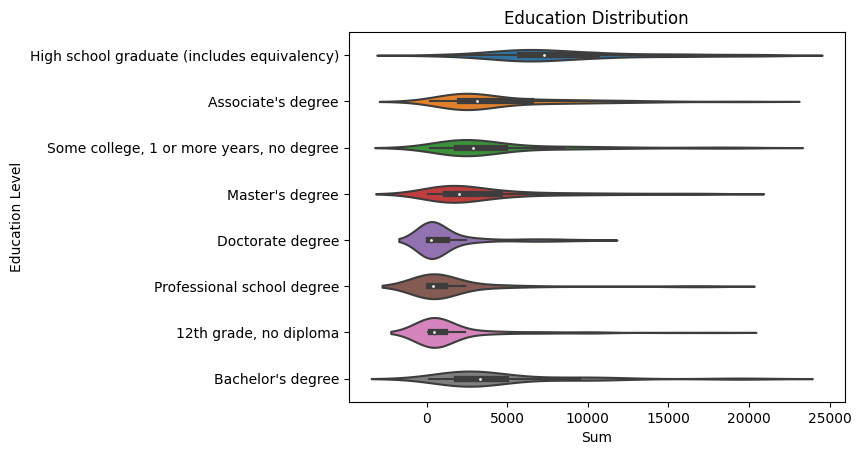

In [83]:
# box plot to visualize educatiom distributions
edu_plot = sns.violinplot(edu_fac, x = "Sum", y = "Education Level")
edu_plot.set_title("Education Distribution")

## Health Insurance

In [25]:
# first want to only keep county, and age ranges and rename
health_ranges = healthDF.drop(["Total:", "Total: Female:", "Total: Male:"], axis = 1)

# remove total
cols = list(health_ranges.columns.values)

with_insur = []
with_out_insur = []
header = ["County", "Age Range", "Sum"]


for i in range(len(health_ranges["County"])):
    
    county = health_ranges["County"][i]

    for j in range(len(cols)):
        
        if ("County" not in cols[j]) & ("health" in cols[j]):
        
            txt = cols[j].split(": ")

            title = txt[2]
            insur = txt[3]

            cur_sum = health_ranges[cols[j]][i]

            if "With" in insur:
                if len(with_insur) != 0:
                    for k in with_insur:

                        if title in k:
                            k[2] = cur_sum + k[2]

                        else:
                            inner = [county, title, cur_sum]

                            with_insur.append(inner)
                            break
                
                else:
                    inner = [county, title, cur_sum]
                    with_insur.append(inner)
                        
            else:
                if len(with_out_insur) != 0:
                    for k in with_insur:

                        if title in k:
                            k[2] = cur_sum + k[2]

                        else:
                            inner = [county, title, cur_sum]

                            with_out_insur.append(inner)
                            break
                            
                else:
                    inner = [county, title, cur_sum]
                    with_out_insur.append(inner)

withDF = pd.DataFrame(with_insur)
withDF = withDF.set_axis(header, axis = 1)

withOutDF = pd.DataFrame(with_out_insur)
withOutDF = withOutDF.set_axis(header, axis = 1)

#### With Health Insurance

In [26]:
# get and remove outliers

Q1 = withDF["Sum"].quantile(.25)
Q3 = withDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(withDF["Sum"] >= upper)[0]
lower_array = np.where(withDF["Sum"] <= lower)[0]

# remove
withDF.drop(index = upper_array, inplace = True)
withDF.drop(index = lower_array, inplace = True)


# create set of outliers
with_outliers = list(lower_array)
for i in list(upper_array):
    with_outliers.append(i)
    
for i in list(with_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Health Insurance Distribtuion')

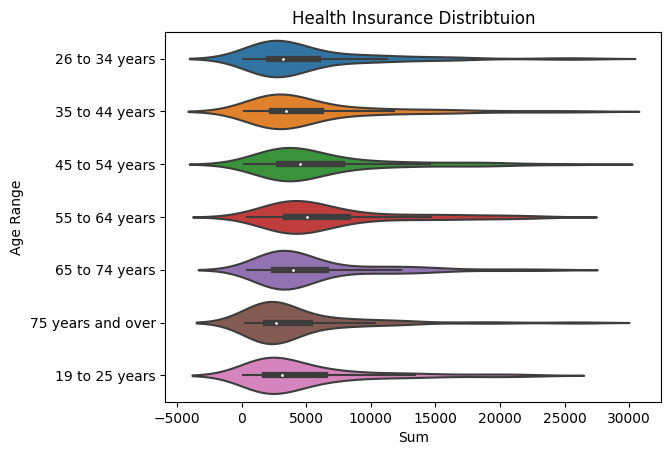

In [82]:
# box plot to visualize age distributions with health insurance
with_plt = sns.violinplot(withDF, x = "Sum", y = "Age Range")
with_plt.set_title("Health Insurance Distribtuion")

#### Without Health Insurance

In [28]:
# get and remove outliers

Q1 = withOutDF["Sum"].quantile(.25)
Q3 = withOutDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(withOutDF["Sum"] >= upper)[0]
lower_array = np.where(withOutDF["Sum"] <= lower)[0]

# remove
withOutDF.drop(index = upper_array, inplace = True)
withOutDF.drop(index = lower_array, inplace = True)


# create set of outliers
with_out_outliers = list(lower_array)
for i in list(upper_array):
    with_out_outliers.append(i)
    
for i in list(with_out_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Without Health Insurance Distribution')

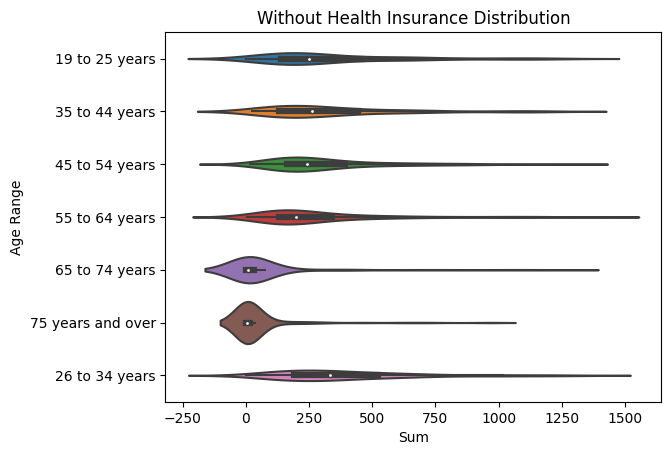

In [81]:
# box plot to visualize age distributions with health insurance
w_o_plt = sns.violinplot(withOutDF, x = "Sum", y = "Age Range")
w_o_plt.set_title("Without Health Insurance Distribution")

## Income

In [33]:
# drop all Total Values
incomeSep = incomeDF.drop(["Total (dollars):", "Total Male (dollars):", "Total Female (dollars):"], axis = 1)


cols = list(incomeSep.columns.values)

new_income = []
header = ["County", "Work Time", "Sum"]

for i in range(len(incomeSep["County"])):
    
    county = incomeSep["County"][i]

    for j in range(len(cols)):
        
        if "County" not in cols[j]:
        
            txt = cols[j].split(": ")

            title = txt[1]

            cur_sum = incomeSep[cols[j]][i]

            if len(new_income) != 0:
                for k in new_income:

                    if title in k:
                        k[2] = cur_sum + k[2]

                    else:
                        inner = [county, title, cur_sum]

                        new_income.append(inner)
                        break
            else:
                inner = [county, title, cur_sum]
                new_income.append(inner)


                
                
incomeSepDF = pd.DataFrame(new_income)
incomeSepDF = incomeSepDF.set_axis(header, axis = 1)

In [34]:
# get and remove outliers

Q1 = incomeSepDF["Sum"].quantile(.25)
Q3 = incomeSepDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(incomeSepDF["Sum"] >= upper)[0]
lower_array = np.where(incomeSepDF["Sum"] <= lower)[0]

# remove
incomeSepDF.drop(index = upper_array, inplace = True)
incomeSepDF.drop(index = lower_array, inplace = True)


# create set of outliers
income_outliers = list(lower_array)
for i in list(upper_array):
    income_outliers.append(i)
    
for i in list(income_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Median Income by Time Worked')

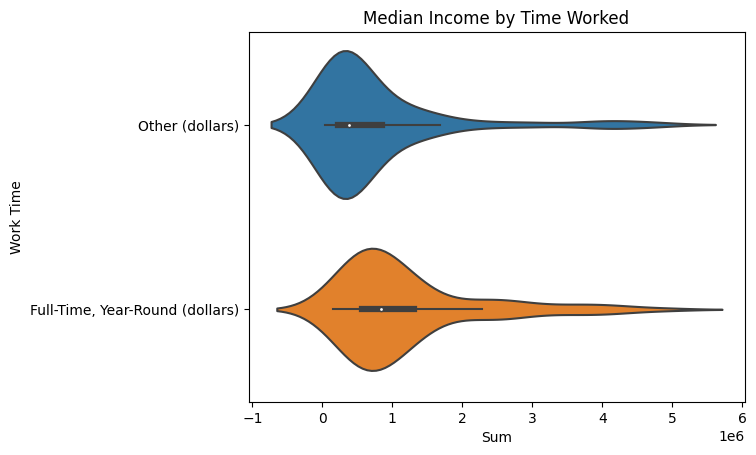

In [80]:
# box plot to visualize median income by work
work_plot = sns.violinplot(incomeSepDF, x = "Sum", y = "Work Time")
work_plot.set_title("Median Income by Time Worked")

## Housing

In [44]:
# drop all Total
housingSep = housingDF.drop(["Total:"], axis = 1)


cols = list(housingSep.columns.values)

new_housing = []
header = ["County", "Housing Type", "Sum"]

for i in range(len(housingSep["County"])):
    
    county = housingSep["County"][i]

    for j in range(len(cols)):
        
        if "County" not in cols[j]:
        
            txt = cols[j].split("Total: ")

            title = txt[1]

            cur_sum = housingSep[cols[j]][i]

            if len(new_housing) != 0:
                for k in new_housing:

                    if title in k:
                        k[2] = cur_sum + k[2]

                    else:
                        inner = [county, title, cur_sum]

                        new_housing.append(inner)
                        break
            else:
                inner = [county, title, cur_sum]
                new_housing.append(inner)


                
                
housingSepDF = pd.DataFrame(new_housing)
housingSepDF = housingSepDF.set_axis(header, axis = 1)

In [45]:
# get and remove outliers

Q1 = housingSepDF["Sum"].quantile(.25)
Q3 = housingSepDF["Sum"].quantile(.75)
IQR = Q3 - Q1

upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

upper_array = np.where(housingSepDF["Sum"] >= upper)[0]
lower_array = np.where(housingSepDF["Sum"] <= lower)[0]

# remove
housingSepDF.drop(index = upper_array, inplace = True)
housingSepDF.drop(index = lower_array, inplace = True)


# create set of outliers
housing_outliers = list(lower_array)
for i in list(upper_array):
    housing_outliers.append(i)
    
for i in list(housing_outliers):
    outliers_set.add(i)

Text(0.5, 1.0, 'Housing Type by Population')

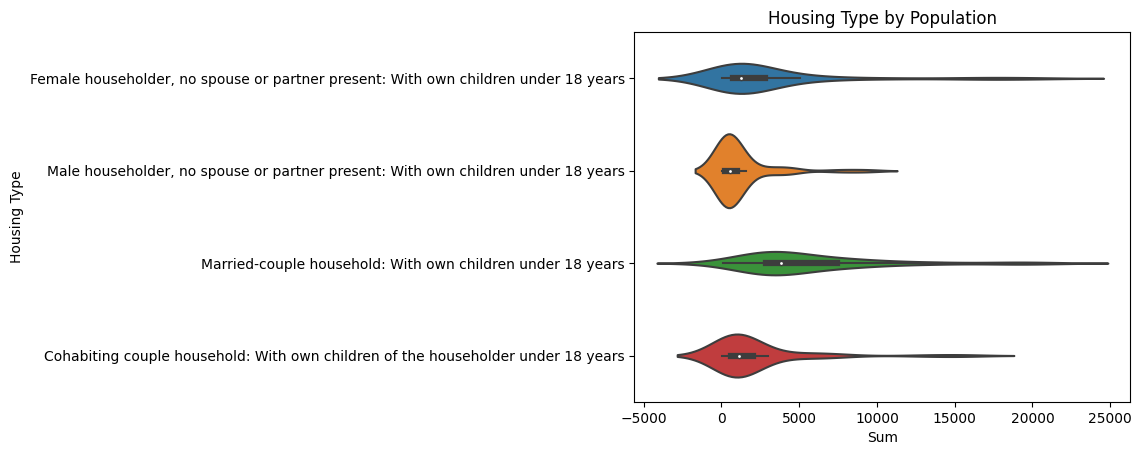

In [79]:
# box plot to visualize Housing Type by Pop
house_plot = sns.violinplot(housingSepDF, x = "Sum", y = "Housing Type")
house_plot.set_title("Housing Type by Population")

#### With Children

In [47]:
# create dataframe only with children

housingChildren = housingSepDF

for i in housingChildren.index:

    housingType = housingChildren["Housing Type"][i]
    
    if "With own children" not in housingType:
        housingChildren.drop(i, inplace = True)

Text(0.5, 1.0, 'Housesholds with Children')

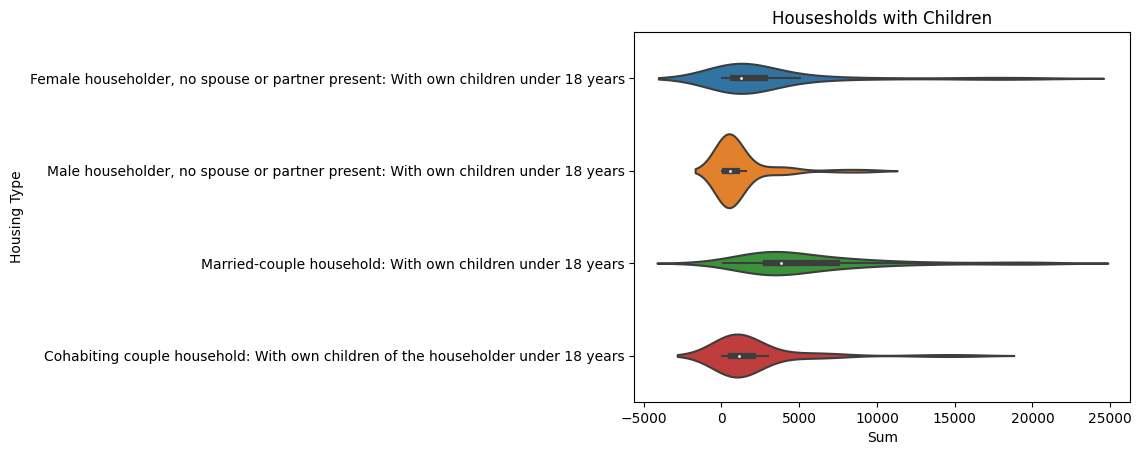

In [78]:
# box plot to visualize With Children Households by Pop
chil_plot = sns.violinplot(housingChildren, x = "Sum", y = "Housing Type")
chil_plot.set_title("Housesholds with Children")

### Remove All Outliers

Using the outliers_set, we can remove all locations where outliers exist for every dataframe.

In [49]:
dataframes = [pres_agg, sexDF, raceDF, educationDF, healthDF, incomeDF, housingDF]

for i in outliers_set:
    
    for j in dataframes:
        
        if i in j.index:
            j.drop(i, inplace = True)

## View Each DataFrame

### President

In [ ]:
pres_agg

In [50]:
# get total votes for each candidate and graph
agg_functions = {'Candidate': 'first', 'Party': 'first', 'Votes': 'sum'}
votes = pres_agg.groupby(['Candidate']).aggregate(agg_functions).reset_index(drop = True)

Text(0.5, 1.0, 'Voting Distribution Per Candidate')

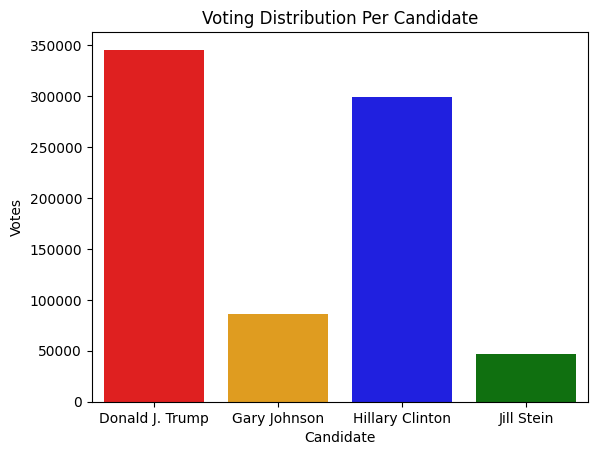

In [51]:
# visualize votes, bar graph

# assign colors
sns.color_palette('muted')
colors = {"Donald J. Trump": 'red', "Gary Johnson": "orange",
          "Hillary Clinton": "blue", "Jill Stein": "green"  }

vote_plt = sns.barplot(votes, x = "Candidate", y = "Votes",
           palette = colors)

vote_plt.set_title("Voting Distribution Per Candidate")

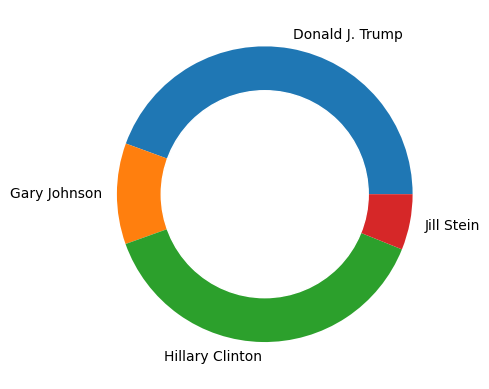

In [52]:
# visualize as donut plot
sns.color_palette('muted')

plt.pie(votes["Votes"], labels = votes["Candidate"])

my_circle = plt.Circle((0,0), 0.7, color = "white")
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

### Sex and Age

In [ ]:
sexDF

In [53]:
# seperate into male and female 

columns = list(sexDF.columns.values)
female = []
male = []

for i in columns:
    
    if "Female" in i:
        female.append(i)
    
    if "male" in i:
        male.append(i)

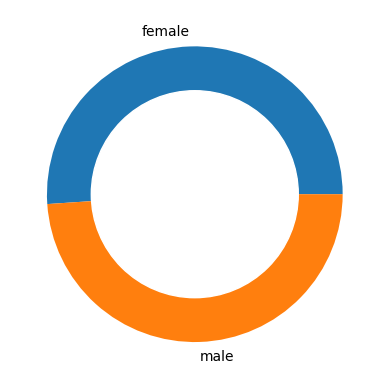

0
Total Female:  1989185.0
Total Male:    1906201.0

In [54]:
# show total female and male
gender_dist = sexDF.sum().to_frame().iloc[2:, :]

gender_dist = gender_dist.loc[["Total Female:", "Total Male:"]]



# # visualize as donut plot
sns.color_palette('muted')

plt.pie(gender_dist[0], labels = ["female", "male"])

my_circle = plt.Circle((0,0), 0.7, color = "white")
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

gender_dist

In [56]:
sex_agg = sexDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)
sex_agg

new_sex = []
header = ["Age Range", "Gender", "Sum"]

columns = list(sexDF.columns.values)

for i in range(len(sex_agg["Labels"])):
    if "Female" in sex_agg["Labels"][i]:
        age = sex_agg["Labels"][i].replace("Total Female: ", "")
        gender = "female"
        f_sum = sex_agg["Sums"][i]
        
    if "Male" in sex_agg["Labels"][i]:
        age = sex_agg["Labels"][i].replace("Total Male: ", "")
        gender = "male"
        f_sum = sex_agg["Sums"][i]
       
    inner = [age, gender, f_sum]
    
    if "Total" in age:
        inner = []
    
    new_sex.append(inner)
    
    
agg_df = pd.DataFrame(new_sex)

agg_df = agg_df.dropna()

agg_df = agg_df.set_axis(["Range", "Gender", "Sum"], axis = 1)

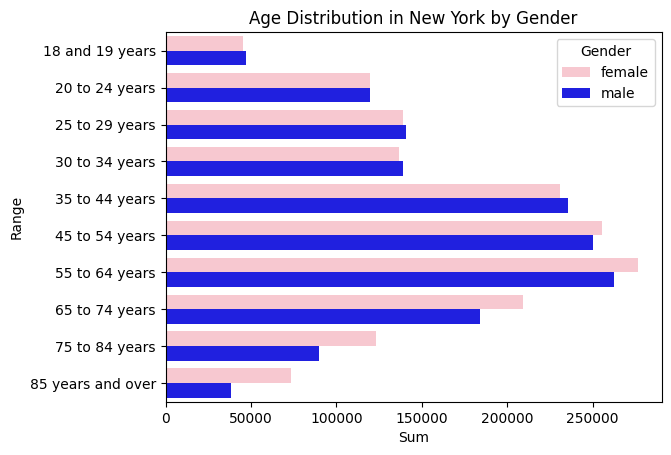

In [57]:
colors = {"female": "pink", "male": "blue"}
rel = sns.barplot(agg_df, x = "Sum", y = "Range", 
                  hue = "Gender", palette = colors).set(title = "Age Distribution in New York by Gender")

#### Total Population Per County

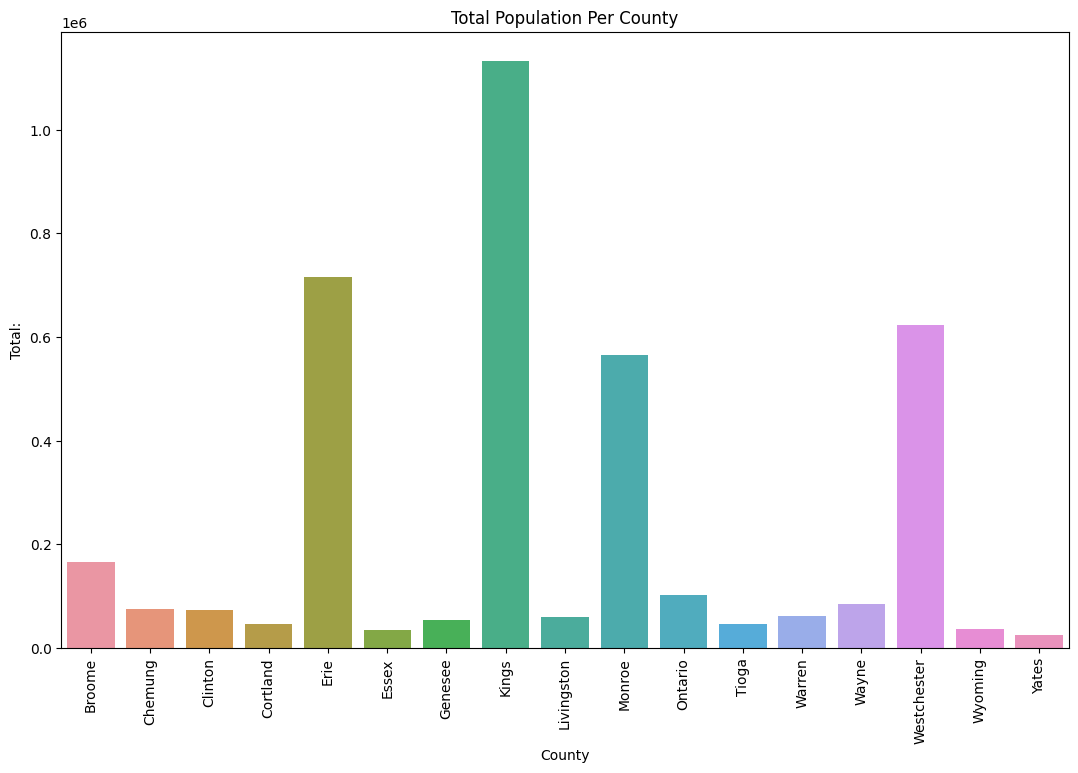

In [58]:
plt.figure(figsize = (13, 8))

pop_plot = sns.barplot(sexDF, x = "County", y = "Total:")

plt.xticks(rotation = 90)

pop_plot.set_title("Total Population Per County")

plt.show()

In [59]:
county_sex = sexDF[["County", "Total:", "Total Male:", "Total Female:"]]

headers = ["County", "Sum", "Gender"]
county_sex_agg = []

for i in county_sex.index:
    
    for j in range(2):
        county = county_sex["County"][i]
        
        if j == 0:
            gender = "male"
            cur_sum = county_sex["Total Male:"][i]
            
        if j == 1:
            gender = "female"
            cur_sum = county_sex["Total Female:"][i]
            
        inner = [county, cur_sum, gender]
        county_sex_agg.append(inner)
    
    
county_sex = pd.DataFrame(county_sex_agg)
county_sex = county_sex.set_axis(headers, axis = 1)


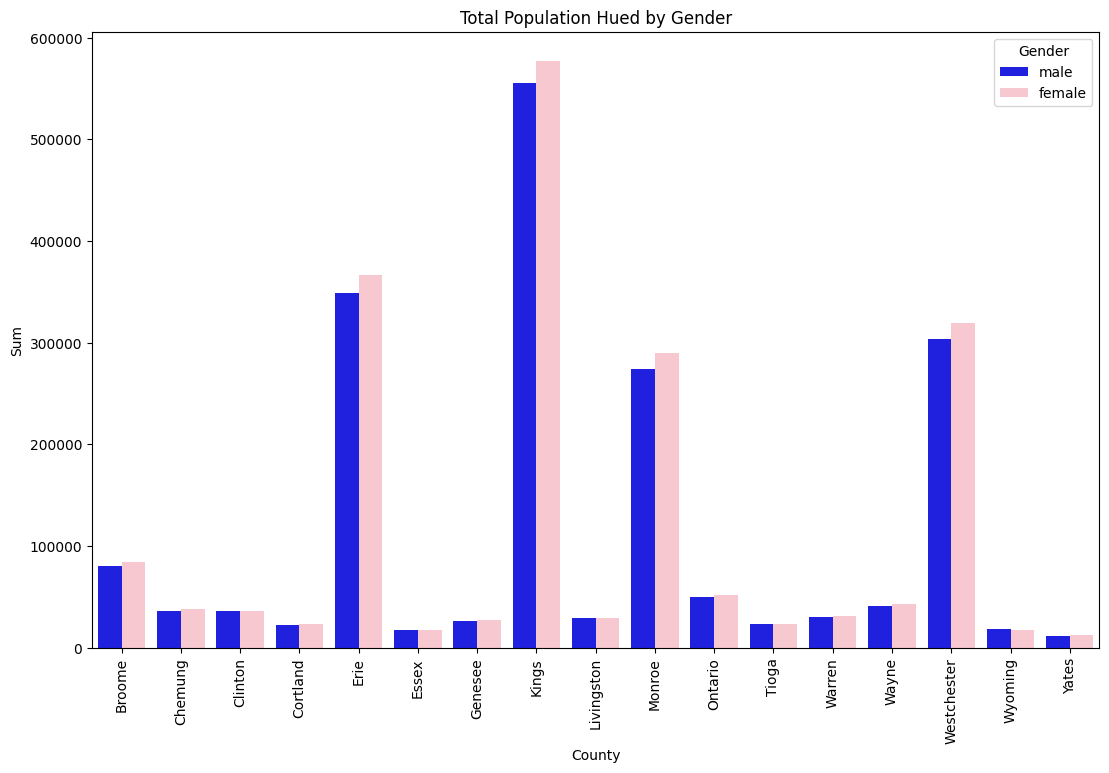

In [60]:
plt.figure(figsize = (13, 8))

c_sex_plot = sns.barplot(county_sex, x = "County", y = "Sum", hue = "Gender", palette = colors)

plt.xticks(rotation = 90)

c_sex_plot.set_title("Total Population Hued by Gender")

plt.show()

### Race

In [ ]:
raceDF

Text(0.5, 1.0, 'Total Population Distributed by Race')

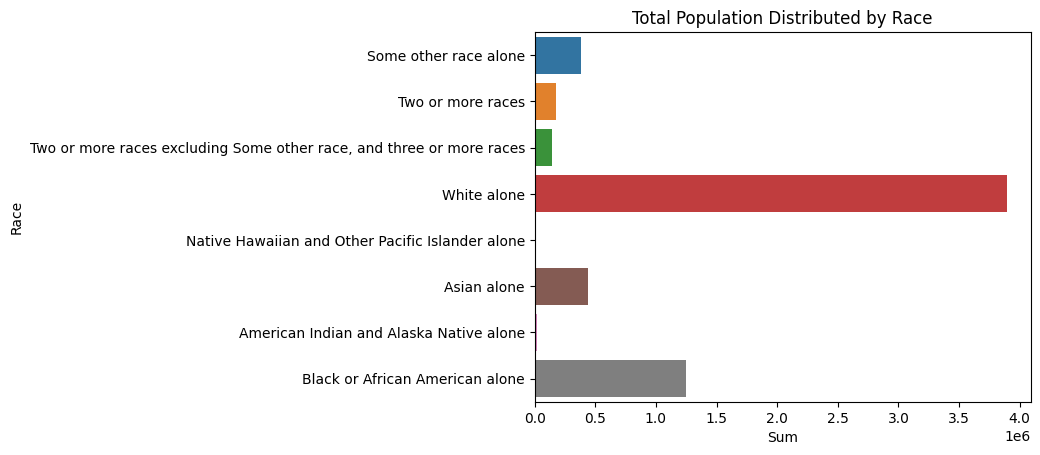

In [61]:
# Total New York
ny_race_tot = raceDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Race", "Sum"], axis = 1)

# rename within in Race to remove "Total" from column
ny_race_tot["Race"] = ny_race_tot["Race"].str.replace("Total: ", "")

# drop Full total count
ny_race_tot = ny_race_tot.drop(index = 4)


# bar plot to visualize
race_plot = sns.barplot(ny_race_tot, x = "Sum", y = "Race")
race_plot.set_title("Total Population Distributed by Race")

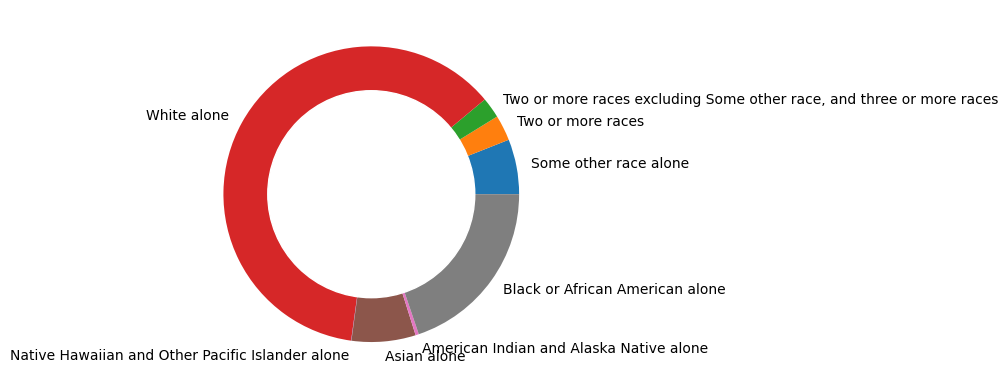

In [62]:
# visualize as donut plot
sns.color_palette('muted')

plt.pie(ny_race_tot["Sum"], labels = ny_race_tot["Race"])

my_circle = plt.Circle((0,0), 0.7, color = "white")
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

### Education 

In [ ]:
educationDF

In [36]:
edu_agg = educationDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)
edu_agg

new_edu = []
header = ["Education Level", "Gender", "Sums"]

columns = list(educationDF.columns.values)

for i in range(len(edu_agg["Labels"])):
    if "Female" in edu_agg["Labels"][i]:
        edu_level = edu_agg["Labels"][i].replace("Total: Female: ", "")
        gender = "female"
        f_sum = edu_agg["Sums"][i]
        
    elif "Male" in edu_agg["Labels"][i]:
        edu_level = edu_agg["Labels"][i].replace("Total: Male: ", "")
        gender = "male"
        f_sum = edu_agg["Sums"][i]
        
    else:
        edu_level = np.nan
        gender = np.nan
        f_sum = np.nan
       
    inner = [edu_level, gender, f_sum]
    
    if "Total" in edu_level:
        inner = []
    
    new_edu.append(inner)
    
    
edu_agg = pd.DataFrame(new_edu)

# drop where "Total:" used to be
edu_agg = edu_agg.dropna()

edu_agg = edu_agg.set_axis(["Education Level", "Gender", "Sum"], axis = 1)



# group by education level for gender hue
group_gender = edu_agg.groupby(["Education Level", "Gender"]).sum().reset_index()

# re index so education level is from lowest to highest
order = ["12th grade, no diploma", "12th grade, no diploma",
         "High school graduate (includes equivalency)", "High school graduate (includes equivalency)",
         "Some college, 1 or more years, no degree", "Some college, 1 or more years, no degree",
         "Professional school degree", "Professional school degree",
         "Associate's degree", "Associate's degree",
         "Bachelor's degree", "Bachelor's degree",
         "Master's degree", "Master's degree",
         "Doctorate degree", "Doctorate degree"]

order_df = pd.DataFrame({'Education Level': order})
order_df['g'] = order_df.groupby('Education Level').cumcount()
group_gender['g'] = group_gender.groupby('Education Level').cumcount()

final = order_df.merge(group_gender).drop(['g'], axis = 1)

0                       1   \
Education Level  12th grade, no diploma  12th grade, no diploma   
Gender                           female                    male   
Sum                            149618.0                151654.0   

                                                          2   \
Education Level  High school graduate (includes equivalency)   
Gender                                                female   
Sum                                                1803224.0   

                                                          3   \
Education Level  High school graduate (includes equivalency)   
Gender                                                  male   
Sum                                                1750522.0   

                                                       4   \
Education Level  Some college, 1 or more years, no degree   
Gender                                             female   
Sum                                              749188.0   

                                                       5   \
Education Level  Some college, 1 or more years, no degree   
Gender                                               male   
Sum                                              733388.0   

                                         6                           7   \
Education Level  Professional school degree  Professional school degree   
Gender                               female                        male   
Sum                                178203.0                    222427.0   

                                 8                   9                  10  \
Education Level  Associate's degree  Associate's degree  Bachelor's degree   
Gender                       female                male             female   
Sum                        675640.0            518584.0          1460702.0   

                                11               12               13  \
Education Level  Bachelor's degree  Master's degree  Master's degree   
Gender                        male           female             male   
Sum                      1344717.0         954975.0         623716.0   

                               14                15  
Education Level  Doctorate degree  Doctorate degree  
Gender                     female              male  
Sum                       94763.0          115326.0

Text(0.5, 1.0, 'Total Education Levels in New York')

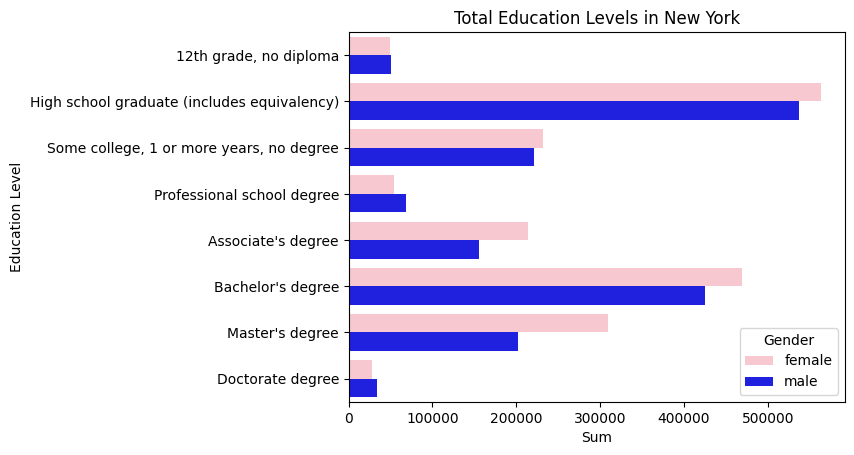

In [64]:
# all education levels, hue by gender to see most common for each gender
edu_plot = sns.barplot(final, x = "Sum", y = "Education Level",
            hue = "Gender", palette = colors)

edu_plot.set_title("Total Education Levels in New York")


In [ ]:
# DO IT BY COUNTY
educationDF

In [6]:
# drop total male and total female
eduDF = educationDF.drop(["Total: Male:", "Total: Female:"], axis = 1)


columns = list(eduDF.columns.values)
headers = ["County", "Education Level", "Gender", "Sum"]

edu_fac = []

for i in eduDF.index:
    
    for j in range(len(columns)):
        
        county = eduDF["County"][i]
        
        
        if "Male:" in columns[j]:
            txt = columns[j]
            sep = columns[j].split(": ")
            
            edu_lev = sep[2]
            gender = "male"
            
            cur_sum = eduDF[columns[j]][i]

            inner = [county, edu_lev, gender, cur_sum]
            
        if "Female:" in columns[j]:
            txt = columns[j]
            sep = columns[j].split(": ")
            
            edu_lev = sep[2]
            gender = "female"
            
            cur_sum = eduDF[columns[j]][i]

            inner = [county, edu_lev, gender, cur_sum]
        
        else:
            inner = []
        
        edu_fac.append(inner)
    
    
edu_fac = pd.DataFrame(edu_fac)

# drop na values
edu_fac = edu_fac.dropna()

edu_fac = edu_fac.set_axis(headers, axis = 1)
edu_fac

County                              Education Level  Gender      Sum
9     Albany                           Associate's degree  female  13526.0
10    Albany     Some college, 1 or more years, no degree  female  10639.0
11    Albany                              Master's degree  female  17281.0
12    Albany                            Bachelor's degree  female  21745.0
13    Albany                             Doctorate degree  female   2422.0
...      ...                                          ...     ...      ...
1066   Yates                            Bachelor's degree  female   1247.0
1067   Yates                             Doctorate degree  female    114.0
1068   Yates                   Professional school degree  female     57.0
1069   Yates                       12th grade, no diploma  female     81.0
1070   Yates  High school graduate (includes equivalency)  female   2445.0

[504 rows x 4 columns]

### Health Insurance

In [43]:
healthDF

County     Total:  Total: Male:  Total: Male: 19 to 25 years:  \
0        Albany   303159.0      146903.0                       20660.0   
1      Allegany    46221.0       23452.0                        3223.0   
2         Bronx  1414023.0      663121.0                       76306.0   
3        Broome   190442.0       93663.0                       12962.0   
4   Cattaraugus    76342.0       37893.0                        3355.0   
..          ...        ...           ...                           ...   
58   Washington    58570.0       29155.0                        2249.0   
59        Wayne    89743.0       44503.0                        3637.0   
60  Westchester   956650.0      462558.0                       40497.0   
61      Wyoming    37846.0       19123.0                        1374.0   
62        Yates    24685.0       11801.0                        1137.0   

    Total: Male: 19 to 25 years: With health insurance coverage  \
0                                             19528.0             
1                                              2965.0             
2                                             64971.0             
3                                             11717.0             
4                                              2783.0             
..                                                ...             
58                                             2041.0             
59                                             3341.0             
60                                            36550.0             
61                                             1188.0             
62                                              879.0             

    Total: Male: 19 to 25 years: No health insurance coverage  \
0                                              1132.0           
1                                               258.0           
2                                             11335.0           
3                                              1245.0           
4                                               572.0           
..                                                ...           
58                                              208.0           
59                                              296.0           
60                                             3947.0           
61                                              186.0           
62                                              258.0           

    Total: Male: 26 to 34 years:  \
0                        17899.0   
1                         2146.0   
2                        95653.0   
3                         9612.0   
4                         3815.0   
..                           ...   
58                        3015.0   
59                        4598.0   
60                       50019.0   
61                        2346.0   
62                        1209.0   

    Total: Male: 26 to 34 years: With health insurance coverage  \
0                                             16040.0             
1                                              1871.0             
2                                             73078.0             
3                                              8318.0             
4                                              3288.0             
..                                                ...             
58                                             2408.0             
59                                             4099.0             
60                                            41008.0             
61                                             2100.0             
62                                              941.0             

    Total: Male: 26 to 34 years: No health insurance coverage  \
0                                              1859.0           
1                                               275.0           
2                                             22575.0           
3                                   

In [45]:
health_agg = healthDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)

new_health = []
header = ["Age", "Insurance", "Gender", "Sums"]

columns = list(healthDF.columns.values)

for i in range(len(health_agg["Labels"])):
    
    if "health" in health_agg["Labels"][i]:
        if "Female" in health_agg["Labels"][i]:
            txt = health_agg["Labels"][i].replace("Total: Female: ", "")
            
            sep = txt.split(": ")
            age = sep[0]
            insure = sep[1]
            
            gender = "female"
            f_sum = health_agg["Sums"][i]

        if "Male" in health_agg["Labels"][i]:
            txt = health_agg["Labels"][i].replace("Total: Male: ", "")
            
            sep = txt.split(": ")
            age = sep[0]
            insure = sep[1]
            
            gender = "male"
            f_sum = health_agg["Sums"][i]
       
        inner = [age, insure, gender, f_sum]
    
    new_health.append(inner)
    
    
health_agg = pd.DataFrame(new_health)

# drop where "Total:" used to be
# also drop where "insurance == male"
health_agg = health_agg.dropna().drop_duplicates()

health_agg = health_agg.set_axis(["Age", "Insurance", "Gender", "Sum"], axis = 1)

health_agg = health_agg.sort_values(by = ["Age"])

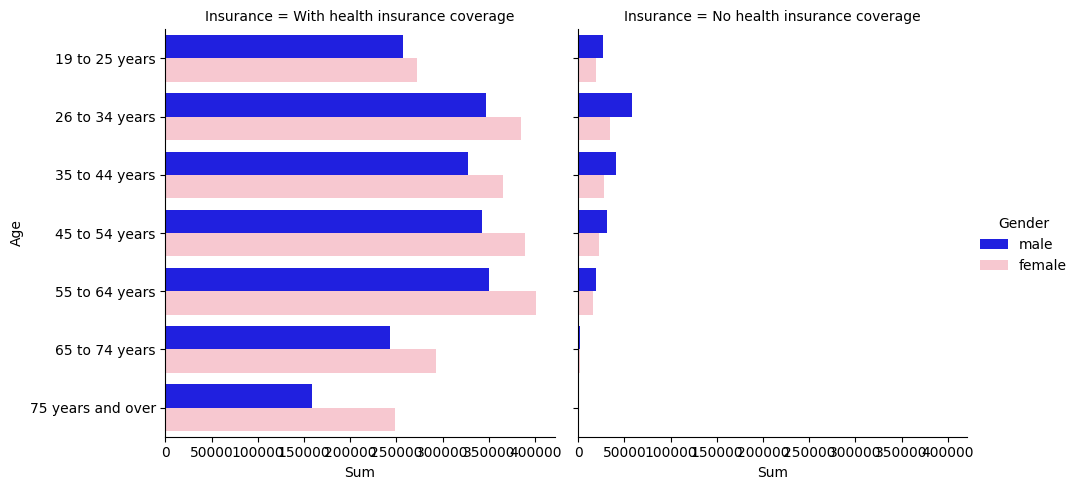

In [66]:
insur_plot = sns.catplot(health_agg, kind = "bar",
           x = "Sum", y = "Age", col = "Insurance",
           hue = "Gender", palette = colors)

In [67]:
# show total with health insurance and total without health insurance
with_out = healthDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)

headers = ["With Health Insurance", "Without Health Insurance"]
w_sum = 0
w_o_sum = 0

for i in range(len(with_out["Labels"])):
    # if with is in label, add sum to with sum
    if "With" in with_out["Labels"][i]:
        w_sum = w_sum + with_out["Sums"][i]
        
    # else add sum to without sum
    elif "No" in with_out["Labels"][i]:
        w_o_sum = w_o_sum + with_out["Sums"][i]
    
sums = [w_sum, w_o_sum]

([<matplotlib.patches.Wedge at 0x2954f74f0>,
 [Text(-1.0771943555363734, 0.22282800632007077, 'With Health Insurance'),
  Text(1.0771943346737047, -0.22282810717428456, 'Without Health Insurance')])

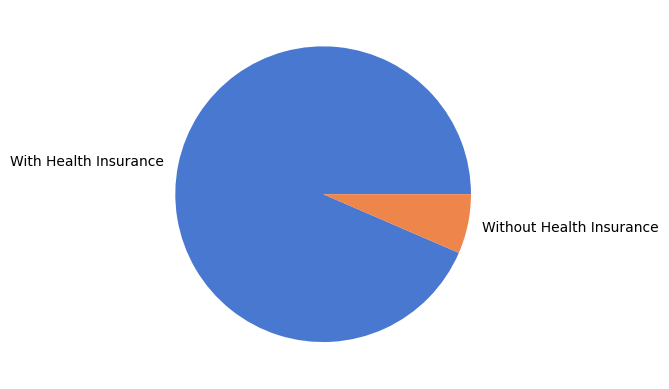

In [68]:
palette_color = sns.color_palette("muted")

plt.pie(sums, labels = headers , colors = palette_color)

### Median Income

In [ ]:
incomeDF

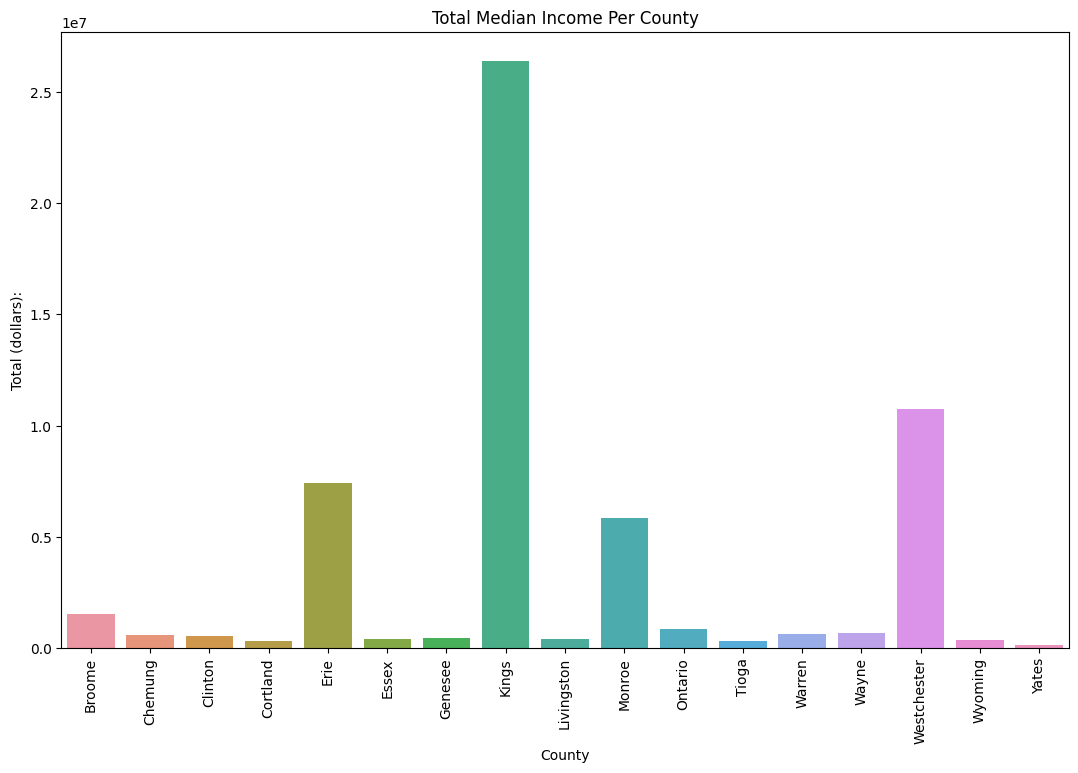

In [69]:
# Total Median Income per County

ax = plt.figure(figsize = (13, 8))

income_plot = sns.barplot(incomeDF, x = "County", y = "Total (dollars):")

plt.xticks(rotation = 90)

income_plot.set_title("Total Median Income Per County")

plt.show()

In [70]:
income_agg = incomeDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)

# drop total male and total female
income_agg = income_agg.drop([0, 3], axis = 0).reset_index()

new_income = []
header = ["Work Status", "Gender", "Total (dollars)"]

for i in range(len(income_agg["Labels"])):      
    
    if "Male:" in income_agg["Labels"][i]:
        txt = income_agg["Labels"][i].replace("Total Male: ", "")
        work = txt.replace("(dollars)", "")
        
        gender = "male"
        
        mon = income_agg["Sums"][i]
        
    if "Female:" in income_agg["Labels"][i]:
        txt = income_agg["Labels"][i].replace("Total Female: ", "")
        work = txt.replace("(dollars)", "")
        
        gender = "female"
        
        mon = income_agg["Sums"][i]
        
    
    inner = [work, gender, mon]
    
    new_income.append(inner)
    
    
income_agg = pd.DataFrame(new_income)

income_agg = income_agg.set_axis(header, axis = 1)


Text(0.5, 1.0, 'Median Income Levels in New York')

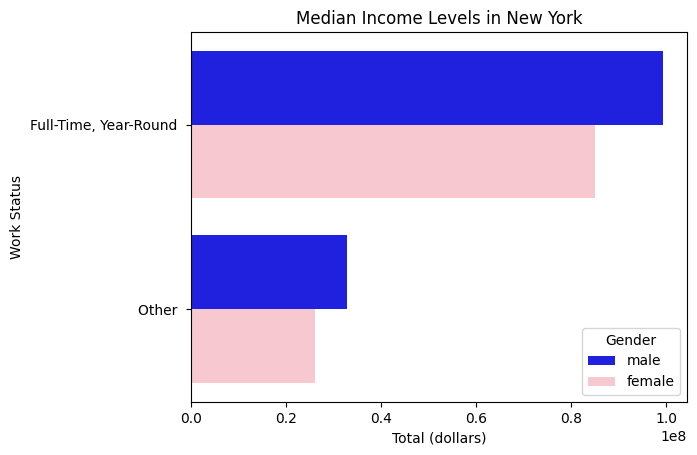

In [71]:
# all education levels, hue by gender to see most common for each gender
in_plot = sns.barplot(income_agg, x = "Total (dollars)", y = "Work Status",
            hue = "Gender", palette = colors)

in_plot.set_title("Median Income Levels in New York")

### Household Size

In [ ]:
housingDF

Housing for single people, hued by gender.

In [48]:
housing_agg = housingDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)

new_housing = []
header = ["Type", "Gender", "Sums"]

columns = list(housingDF.columns.values)

for i in range(len(housing_agg["Labels"])):
    if "Female" in housing_agg["Labels"][i]:
        housing_type = housing_agg["Labels"][i].replace("Total: Female ", "")
        gender = "female"
        f_sum = housing_agg["Sums"][i]
        
    elif "Male" in housing_agg["Labels"][i]:
        housing_type = housing_agg["Labels"][i].replace("Total: Male ", "")
        gender = "male"
        f_sum = housing_agg["Sums"][i]
        
    else:
        housing_type = np.nan
        gender = np.nan
        f_sum = np.nan
       
    inner = [housing_type, gender, f_sum]
    
    if "Total" in edu_level:
        inner = []
    
    new_housing.append(inner)
    
    
housing_agg = pd.DataFrame(new_housing)

# drop where "Total:" used to be
housing_agg = housing_agg.dropna()

housing_agg = housing_agg.set_axis(header, axis = 1)

Text(0.5, 1.0, 'Single Households')

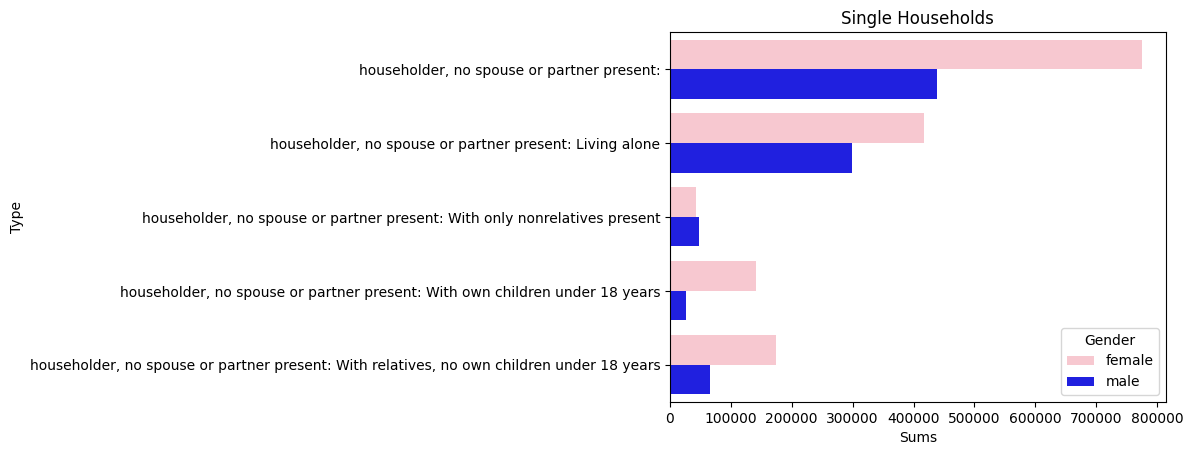

In [73]:
# single housing, hue by gender to see most common for each gender
housing_gen = sns.barplot(housing_agg, x = "Sums", y = "Type",
            hue = "Gender", palette = colors)

housing_gen.set_title("Single Households")


Cohaibiting or Married Households

In [74]:
cohab_mar = housingDF.sum().to_frame().iloc[2:, :].reset_index().set_axis(["Labels", "Sums"], axis = 1)

for i in cohab_mar.index:
    
    if ("Cohabiting" not in cohab_mar["Labels"][i]) & ("Married" not in cohab_mar["Labels"][i]):
        
        cohab_mar.drop(i, inplace = True)
        
        
for i in cohab_mar.index:
    
    cohab_mar["Labels"][i] = cohab_mar["Labels"][i].replace("Total: ", "")

Text(0.5, 1.0, 'Total Population of Households: Cohabiting or Married')

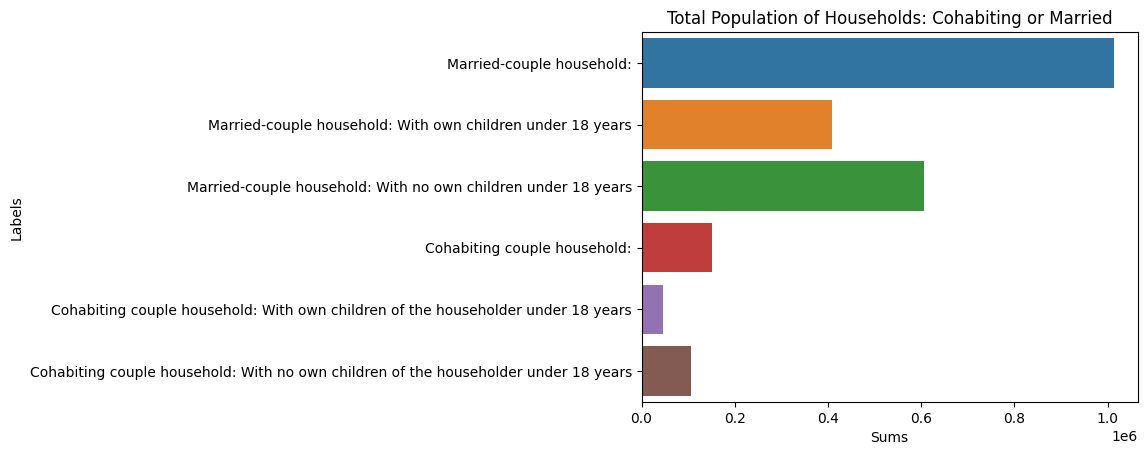

In [77]:
cohab_plot = sns.barplot(cohab_mar, x = "Sums", y = "Labels")
cohab_plot.set_title("Total Population of Households: Cohabiting or Married")

# Comparisons






### Race

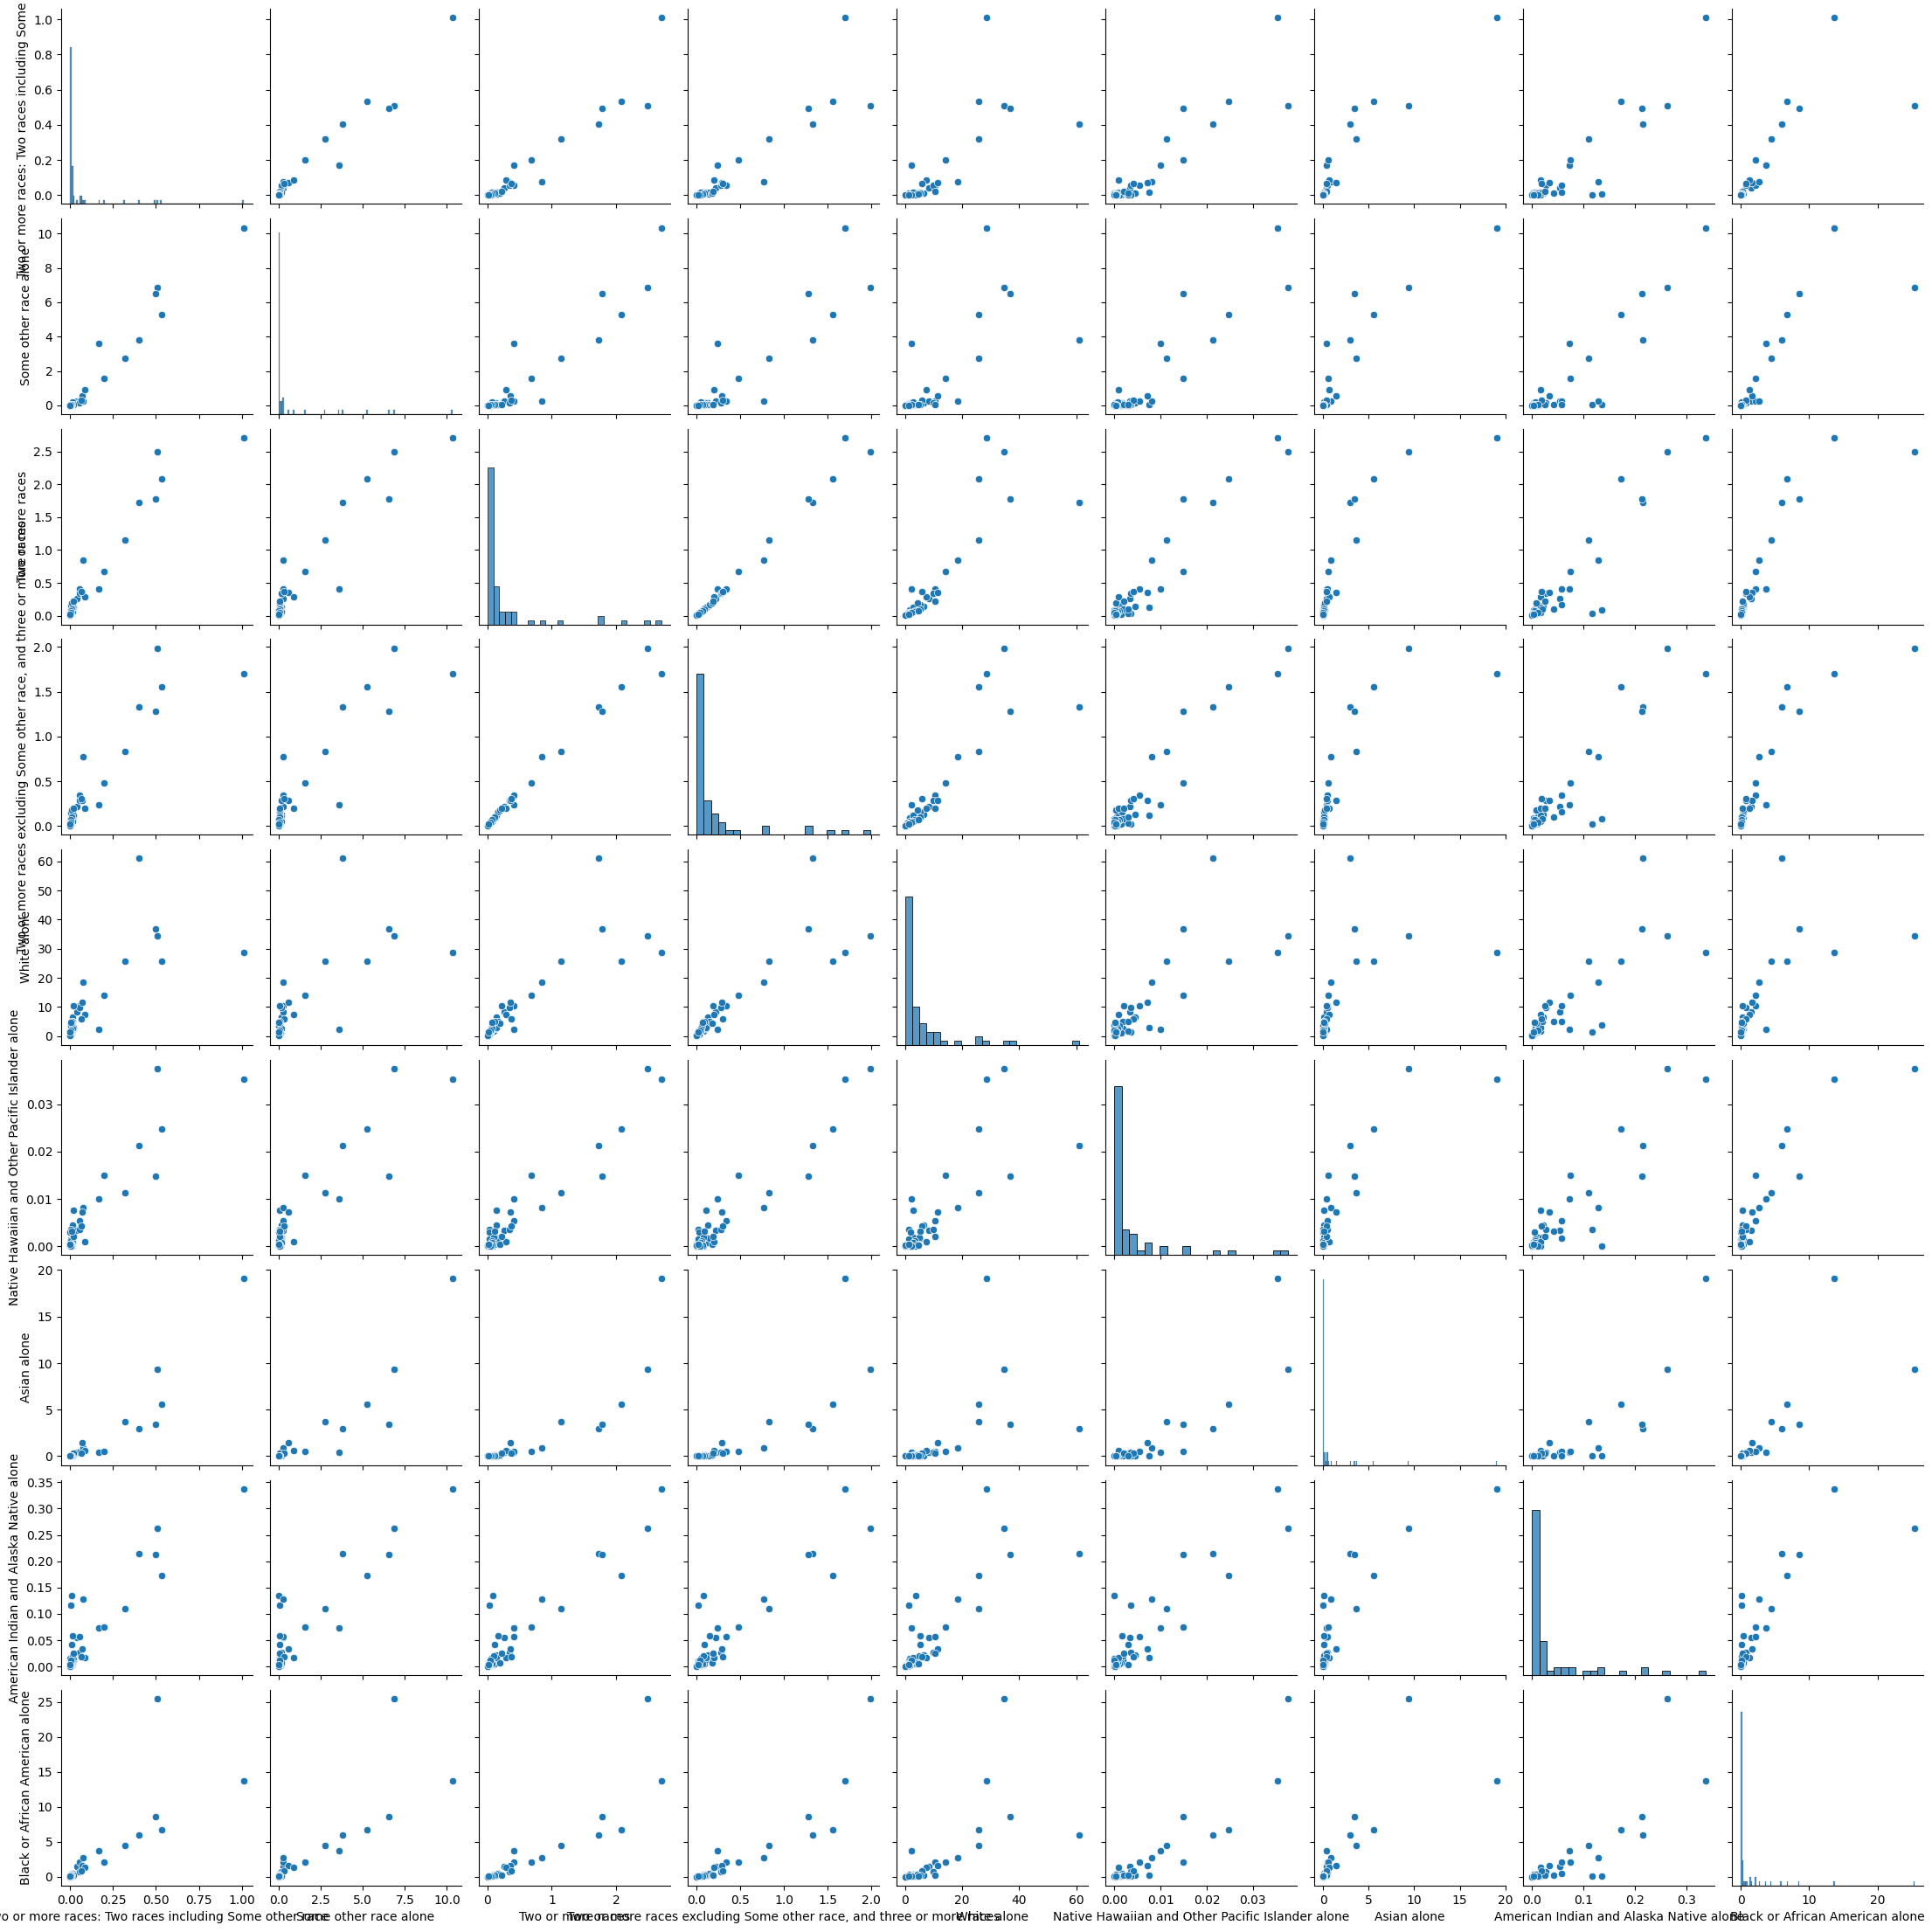

In [80]:
# merge raceDF with votes per county

race_votes = raceDF.drop(["Total:"], axis = 1)

# get only race columns
race_cols = list(race_votes.columns.values)
race_cols.remove("County")

race_votes["Votes"] = pres_agg["Votes Per County"]

# divide race counts by vote per county
# should give percent of race community included in voting data
race_votes = race_votes[race_cols].div(race_votes["Votes"], axis = 0).drop(["Votes"], axis = 1)


race_cols = []
new_cols = []
# drop total from column heads
for i in range(len(list(race_votes.columns.values))):
    val = list(race_votes.columns.values)[i]
    if "Total:" in list(race_votes.columns.values)[i]:
        val = list(race_votes.columns.values)[i].replace("Total: ", "")
        race_cols.append(val)
        
    new_cols.append(val)
    

race_votes = race_votes.set_axis(new_cols, axis = 1)

sns.pairplot(race_votes)
# shows that not everyone in the county voted, there are multiple points over 1, 
# meaning that more than 100% of that community voted, which does not make sense

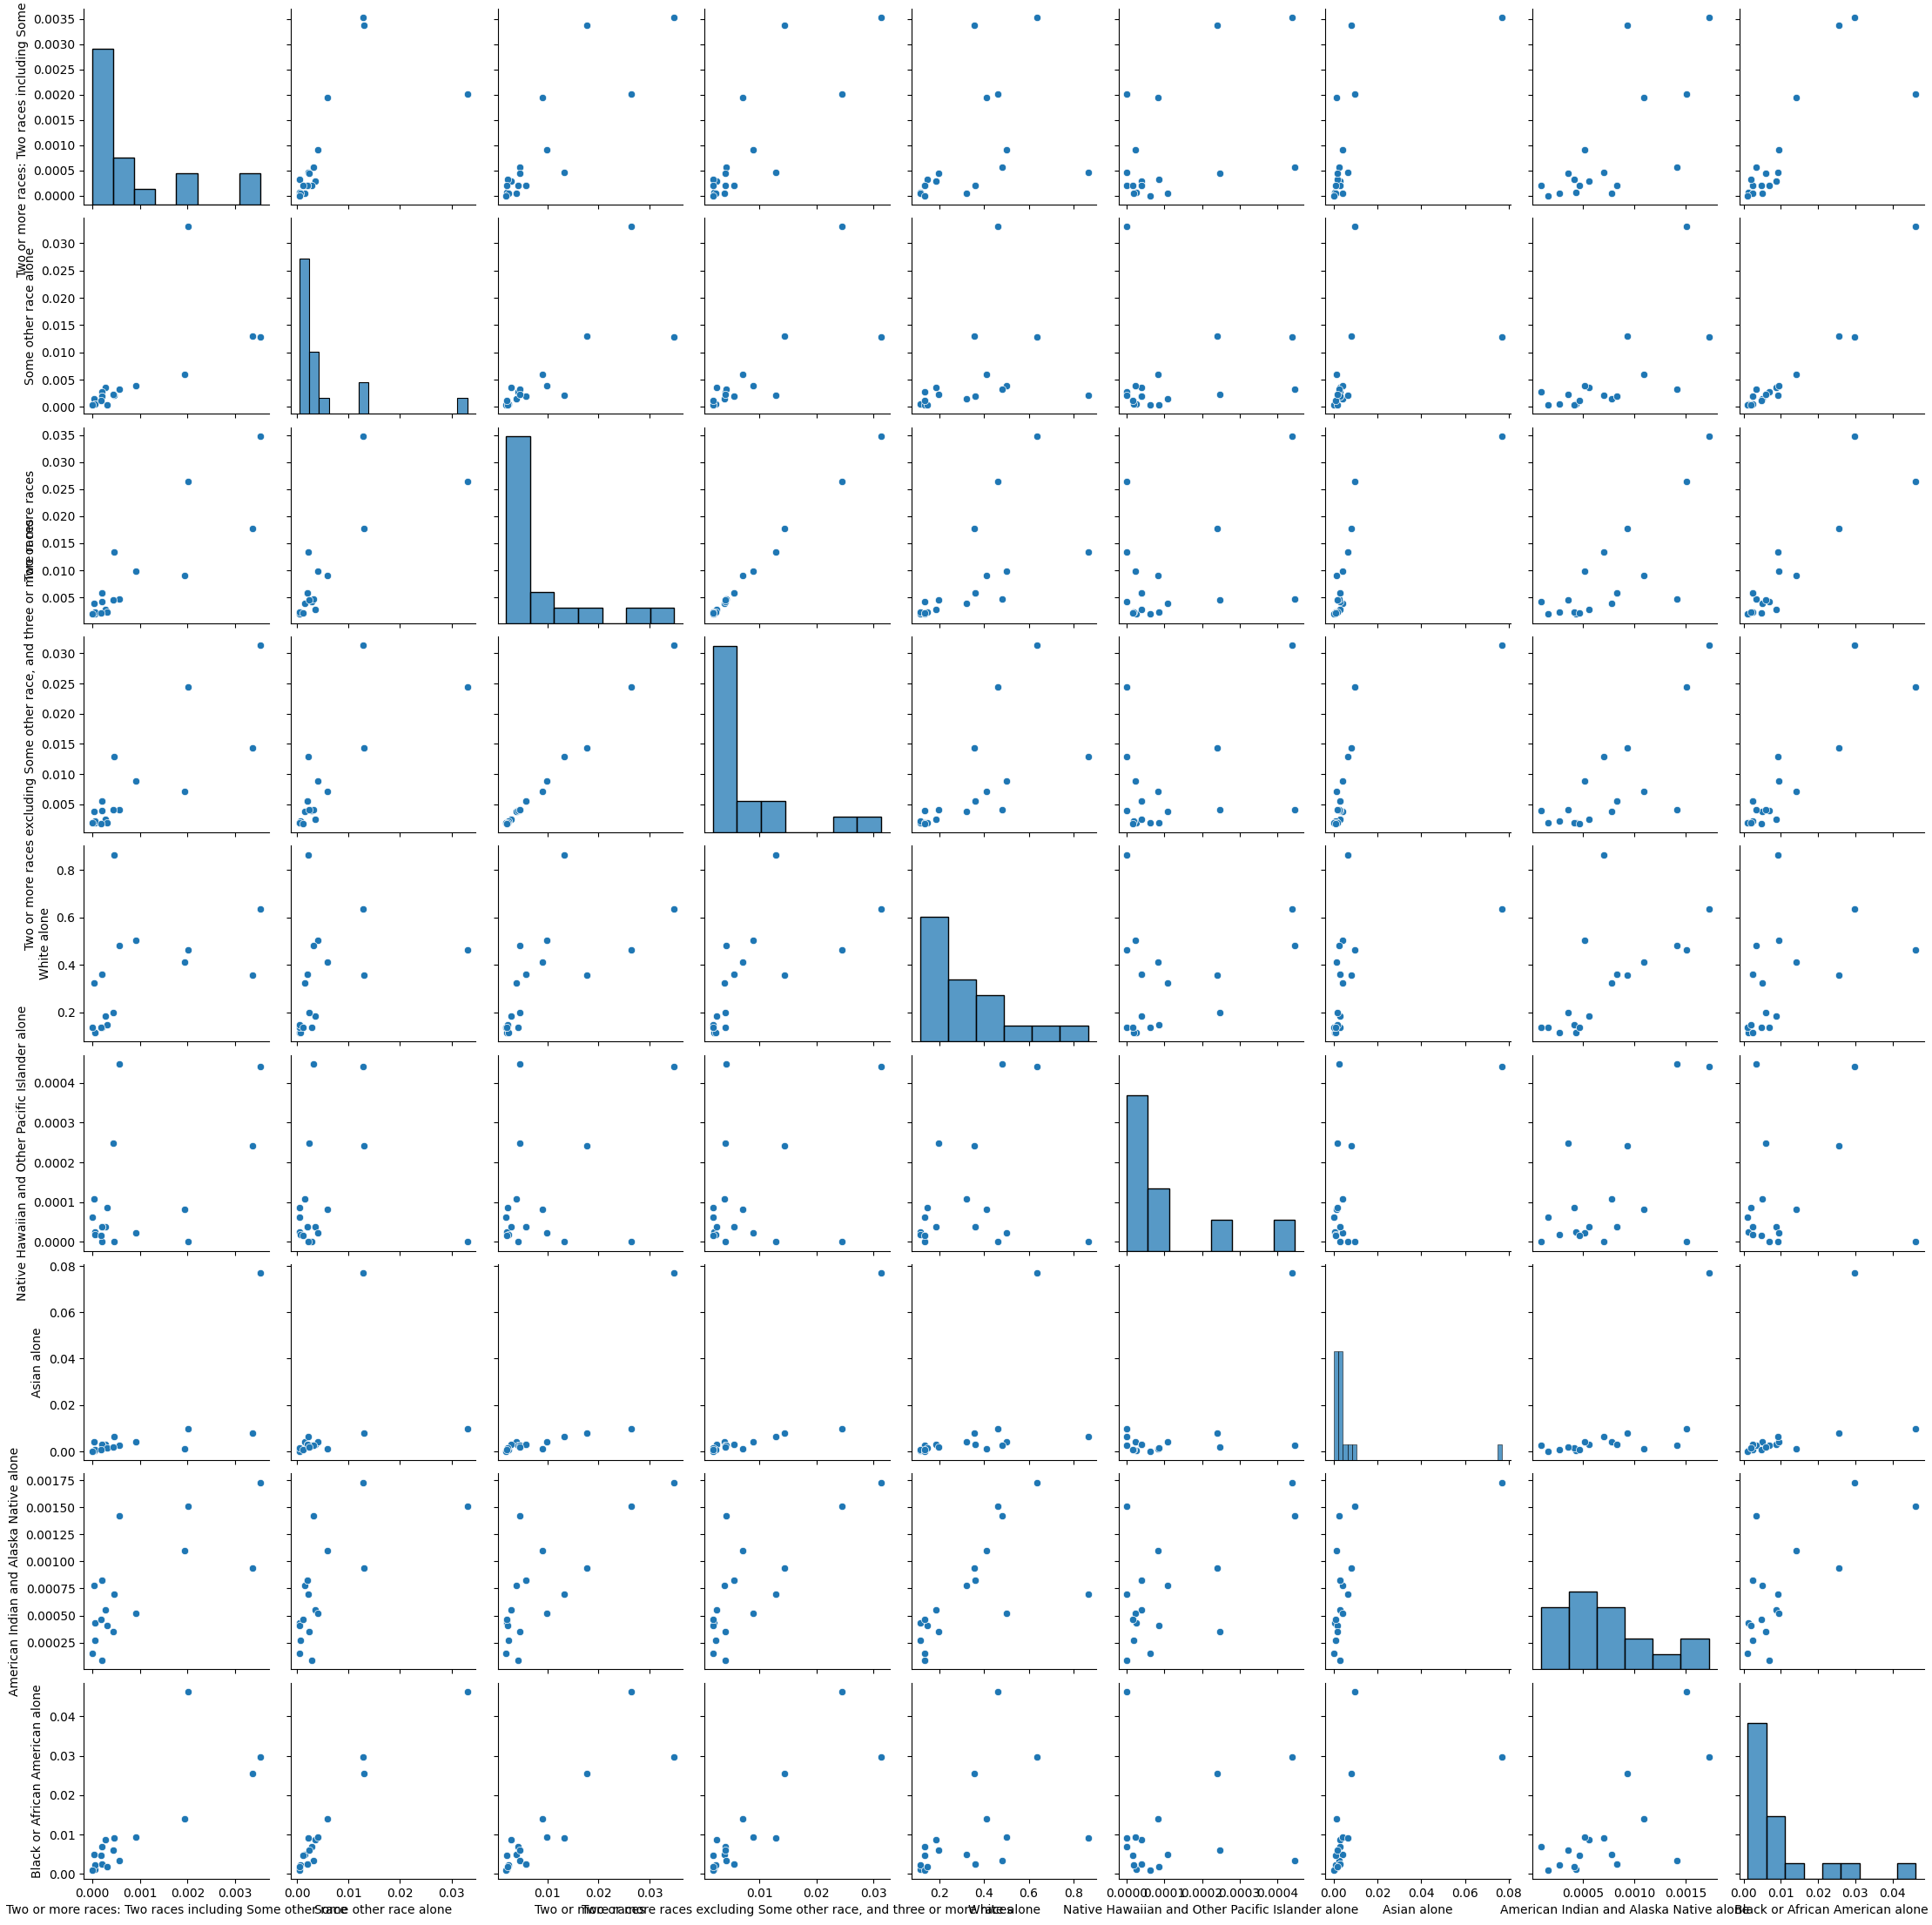

In [100]:
# remove all values over
for i in race_cols:
    race_votes = race_votes.loc[race_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(race_votes)

### Education

In [84]:
edu = educationDF.drop(["Total: Male:", "Total: Female:"], axis = 1)

# # to be useable for pairplot, sum for each type of education
edu_sums = [edu["County"],
            edu["Total: Male: 12th grade, no diploma"] + edu["Total: Female: 12th grade, no diploma"],
            edu["Total: Male: High school graduate (includes equivalency)"] + edu["Total: Female: High school graduate (includes equivalency)"],
            edu["Total: Male: Professional school degree"] + edu["Total: Female: Professional school degree"],
            edu["Total: Male: Some college, 1 or more years, no degree"] + edu["Total: Female: Some college, 1 or more years, no degree"],
            edu["Total: Male: Associate's degree"] + edu["Total: Female: Associate's degree"],
            edu["Total: Male: Bachelor's degree"] + edu["Total: Female: Bachelor's degree"],
            edu["Total: Male: Master's degree"] + edu["Total: Female: Master's degree"],
            edu["Total: Male: Doctorate degree"] + edu["Total: Female: Doctorate degree"]]

edu_sums = pd.DataFrame(edu_sums).T.set_axis(["County", "12th Grade, No Diploma",
                                             "High School Graduate",
                                             "Professional School Degree",
                                             "Some College, 1 or More Years, No Degree",
                                             "Associate's Degree",
                                             "Bachelor's Degree",
                                             "Master's Degree",
                                             "Doctorate Degree"], axis = 1)

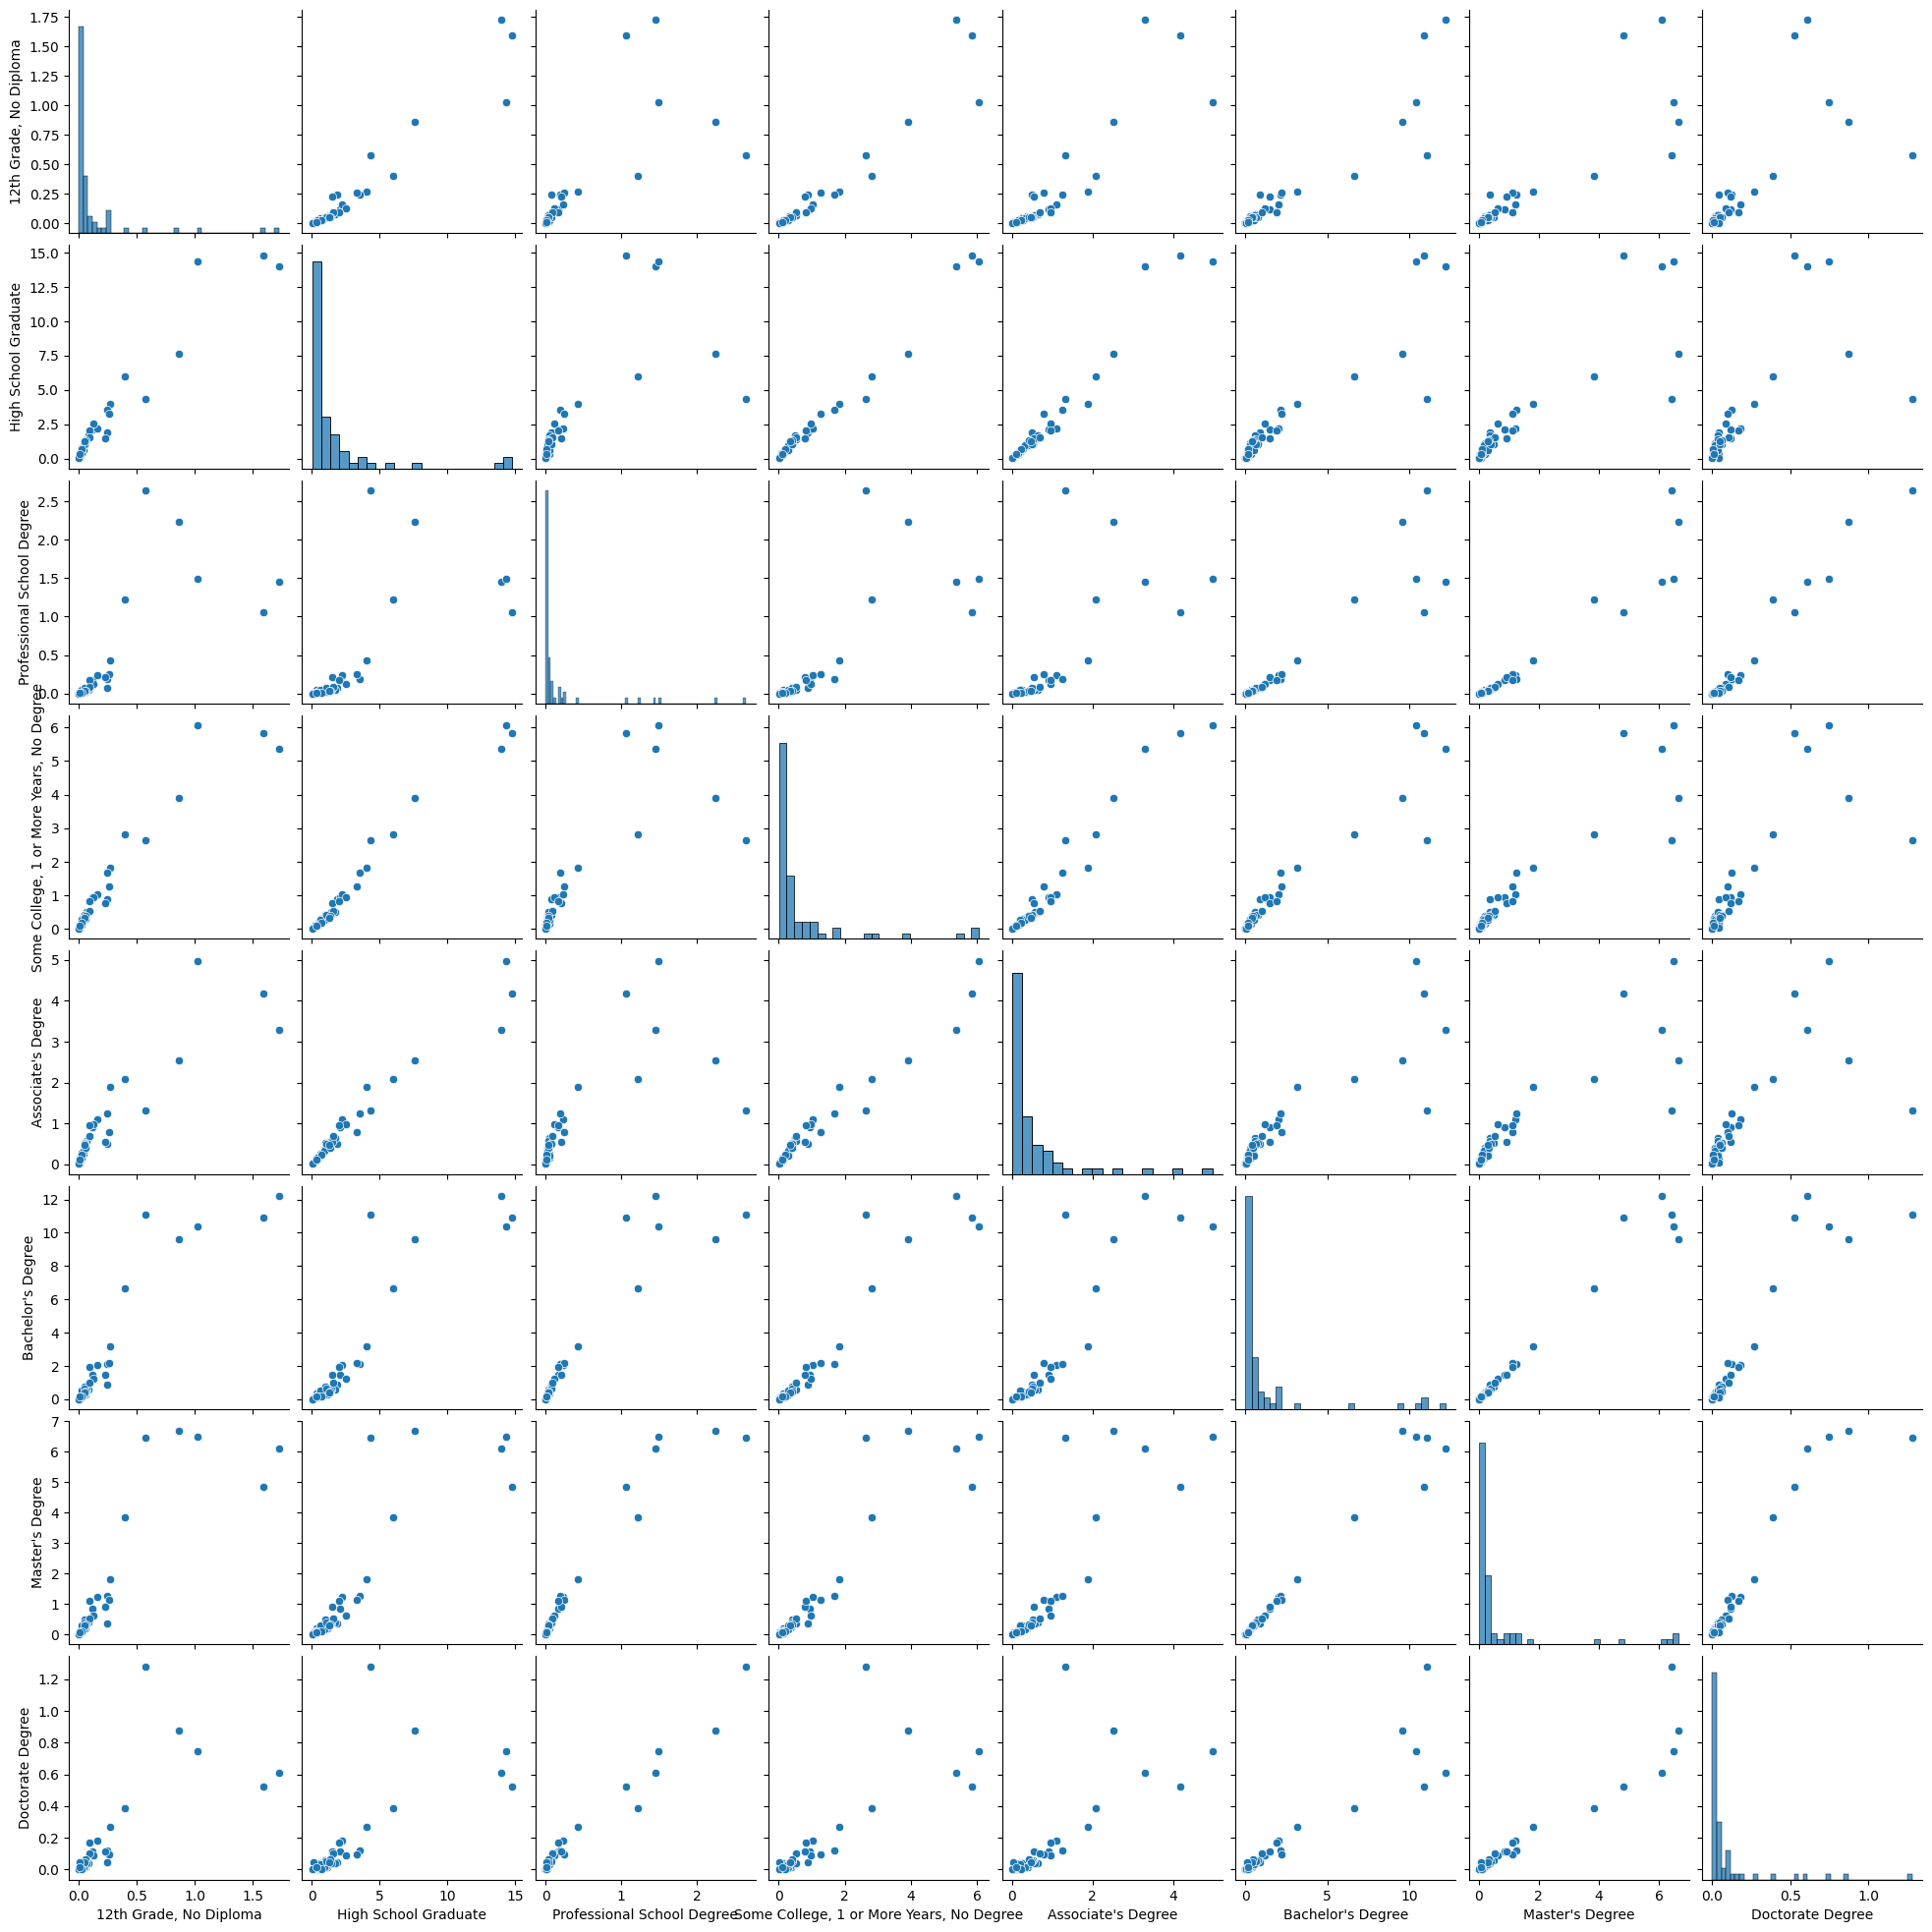

In [91]:
# merge edu_sums with votes per county

edu_votes = edu_sums.drop(["County"], axis = 1)

# get education columns
edu_cols = list(edu_votes.columns.values)

edu_votes["Votes"] = pres_agg["Votes Per County"]


# divide education counts by vote per county
# should give percent of community included in voting data
edu_votes = edu_votes[edu_cols].div(edu_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(edu_votes)

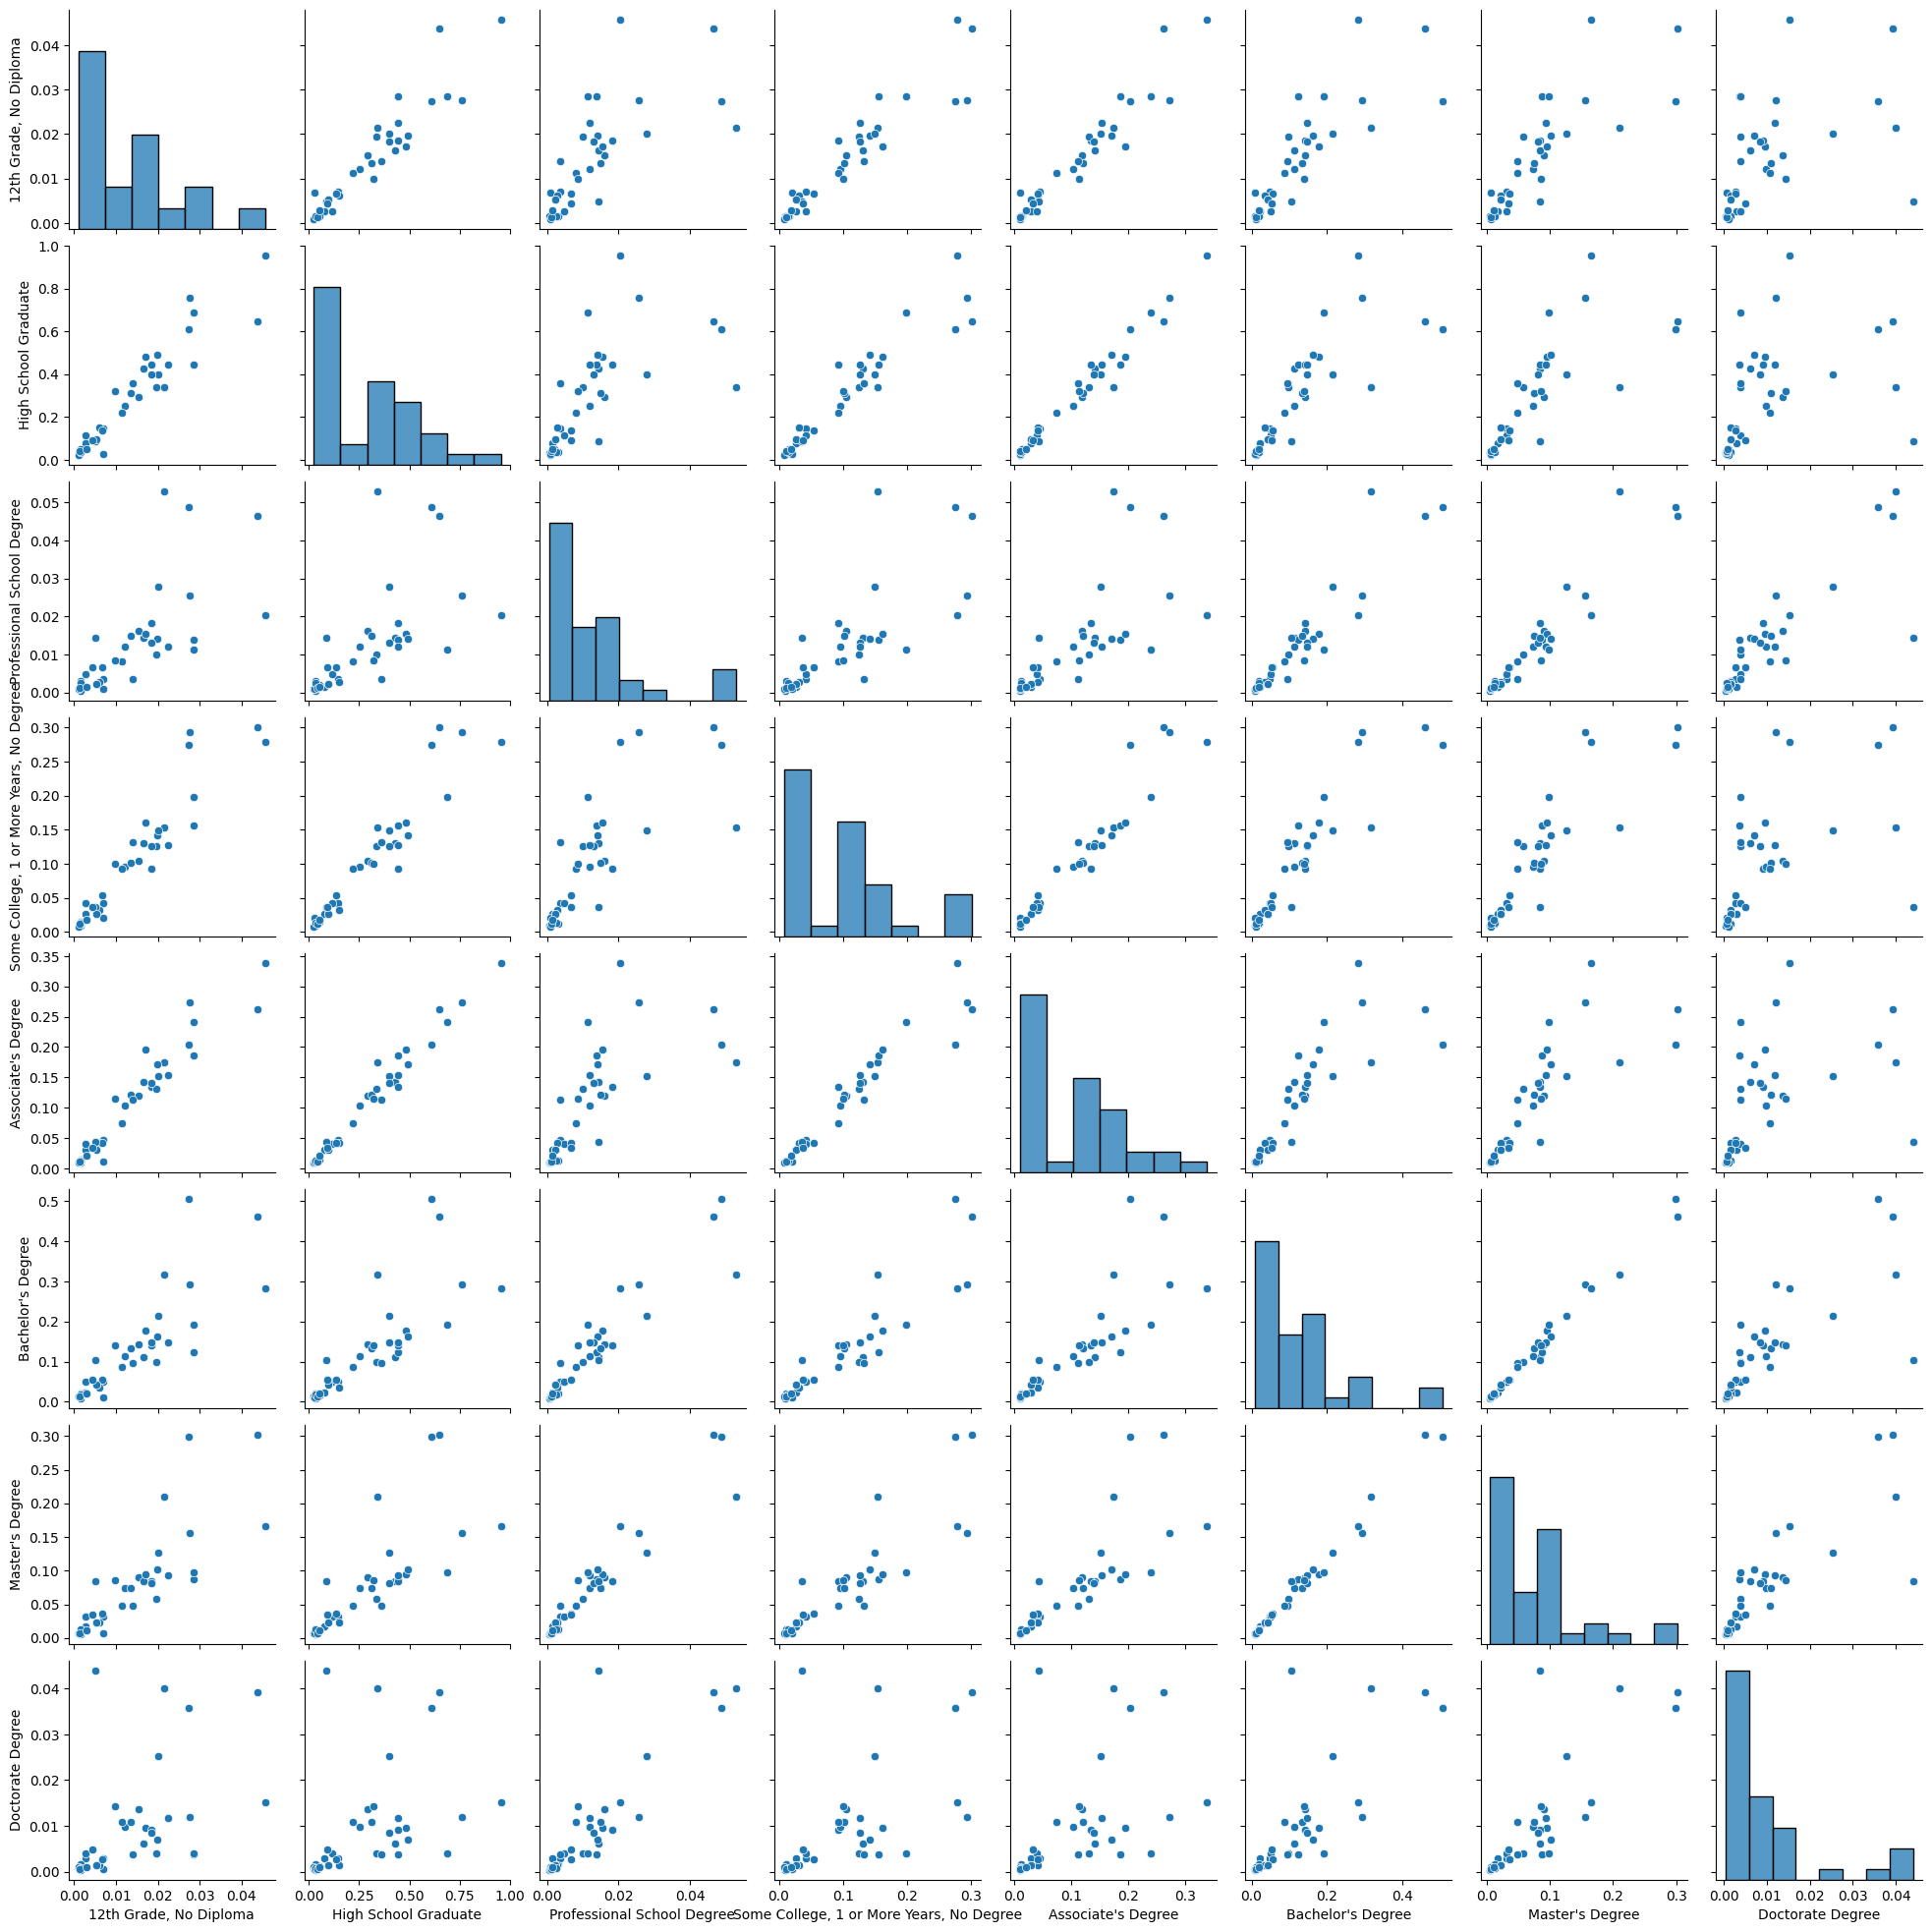

In [99]:
# remove values over 100%
for i in edu_cols:
    edu_votes = edu_votes.loc[edu_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(edu_votes)

### Health 

In [93]:
# to be useable for pairplot, sum for each type of age/health insurance coverage

health = [healthDF["County"],
          healthDF["Total: Male: 19 to 25 years: With health insurance coverage"] + \
          healthDF["Total: Female: 19 to 25 years: With health insurance coverage"],
          healthDF["Total: Male: 19 to 25 years: No health insurance coverage"] + \
          healthDF["Total: Female: 19 to 25 years: No health insurance coverage"],
          healthDF["Total: Male: 26 to 34 years: With health insurance coverage"] + \
          healthDF["Total: Female: 26 to 34 years: With health insurance coverage"],
          healthDF["Total: Male: 26 to 34 years: No health insurance coverage"] + \
          healthDF["Total: Female: 26 to 34 years: No health insurance coverage"],
          healthDF["Total: Male: 35 to 44 years: With health insurance coverage"] + \
          healthDF["Total: Female: 35 to 44 years: With health insurance coverage"],
          healthDF["Total: Male: 35 to 44 years: No health insurance coverage"] + \
          healthDF["Total: Female: 35 to 44 years: No health insurance coverage"],
          healthDF["Total: Male: 45 to 54 years: With health insurance coverage"] + \
          healthDF["Total: Female: 45 to 54 years: With health insurance coverage"],
          healthDF["Total: Male: 45 to 54 years: No health insurance coverage"] + \
          healthDF["Total: Female: 45 to 54 years: No health insurance coverage"],
          healthDF["Total: Male: 55 to 64 years: With health insurance coverage"] + \
          healthDF["Total: Female: 55 to 64 years: With health insurance coverage"],
          healthDF["Total: Male: 55 to 64 years: No health insurance coverage"] + \
          healthDF["Total: Female: 55 to 64 years: No health insurance coverage"],
          healthDF["Total: Male: 65 to 74 years: With health insurance coverage"] + \
          healthDF["Total: Female: 65 to 74 years: With health insurance coverage"],
          healthDF["Total: Male: 65 to 74 years: No health insurance coverage"] + \
          healthDF["Total: Female: 65 to 74 years: No health insurance coverage"],
          healthDF["Total: Male: 75 years and over: With health insurance coverage"] + \
          healthDF["Total: Female: 75 years and over: With health insurance coverage"],
          healthDF["Total: Male: 75 years and over: No health insurance coverage"] + \
          healthDF["Total: Female: 75 years and over: No health insurance coverage"]]

health_sums = pd.DataFrame(health).T.set_axis(["County",
                                               "19 to 25 years: With Health Insurance",
                                               "19 to 25 years: No Health Insurance",
                                               "26 to 34 years: With Health Insurance",
                                               "36 to 34 years: No Health Insurance",
                                               "35 to 44 years: With Health Insurance",
                                               "35 to 44 years: No Health Insurance",
                                               "45 to 54 years: With Health Insurance",
                                               "45 to 54 years: No Health Insurance",
                                               "55 to 64 years: With Health Insurance",
                                               "55 to 64 years: No Health Insurance",
                                               "65 to 74 years: With Health Insurance",
                                               "65 to 74 years: No Health Insurance",
                                               "75 years and over: With Health Insurance",
                                               "75 years and over: No Health Insurance"], axis = 1)

#### With Health Insurance

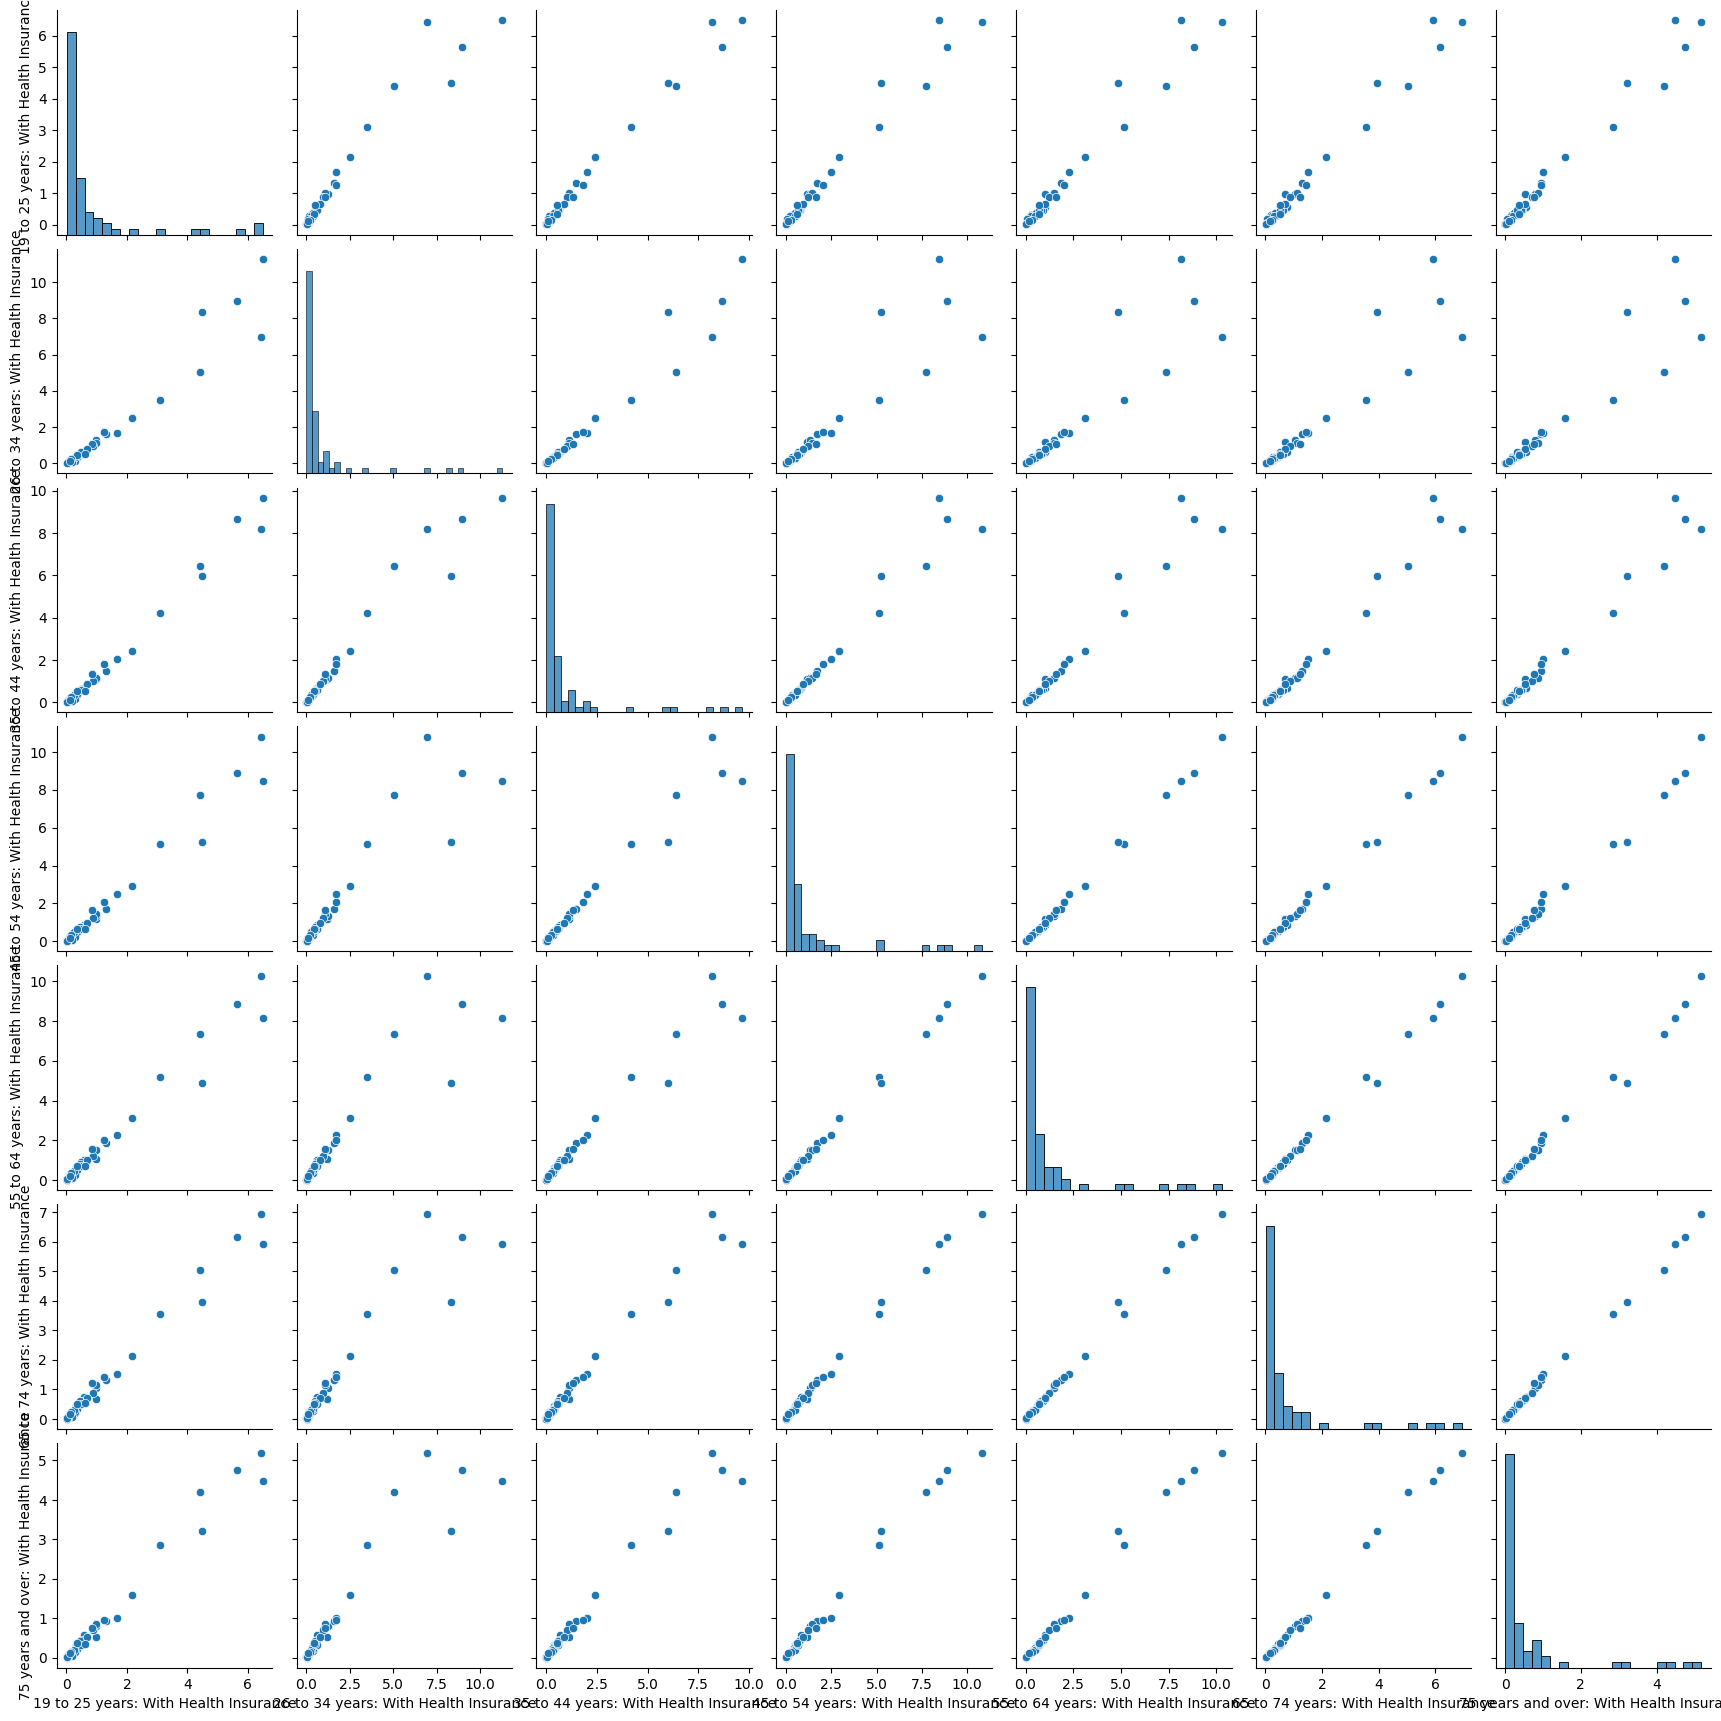

In [108]:
# merge health_sums with votes per county

# get education columns
health_cols = list(health_sums.columns.values)

health_with = []
health_wo = []
for i in health_cols:
    if "With" in i:
        health_with.append(i)
    else:
        health_wo.append(i)


health_votes = health_sums[health_with]

health_votes["Votes"] = pres_agg["Votes Per County"]

health_cols2 = list(health_votes.columns.values)
health_cols2.remove("Votes")

# divide education counts by vote per county
# should give percent of community included in voting data
health_votes = health_votes[health_cols2].div(health_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(health_votes)

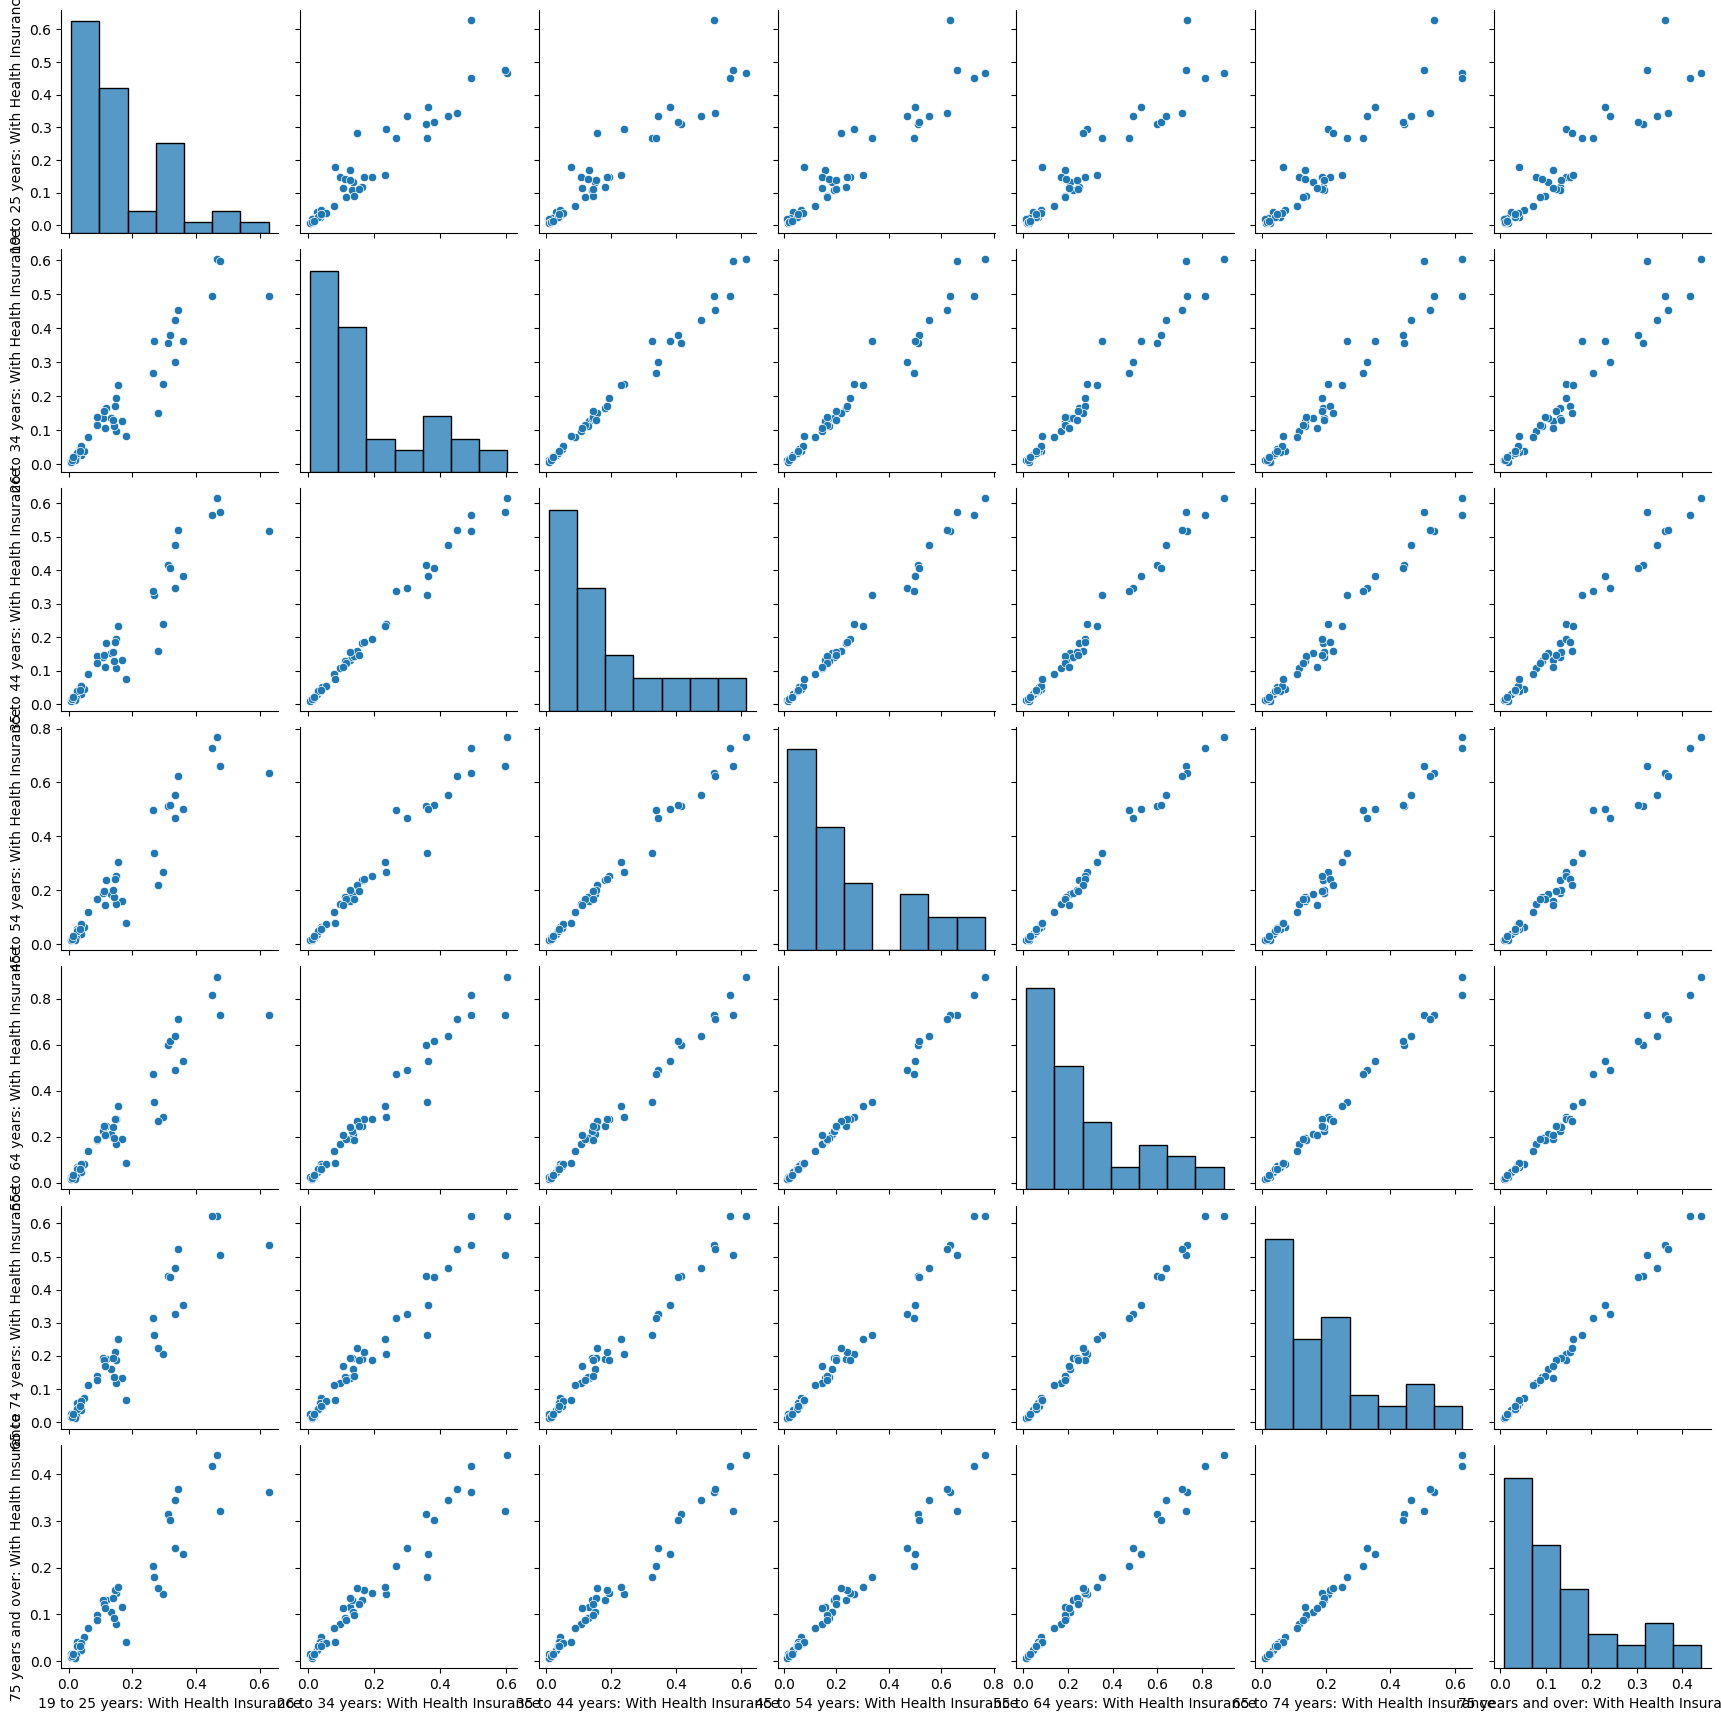

In [109]:
# remove values over 100%
for i in health_cols2:
    health_votes = health_votes.loc[health_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(health_votes)

#### Without Health Insurance

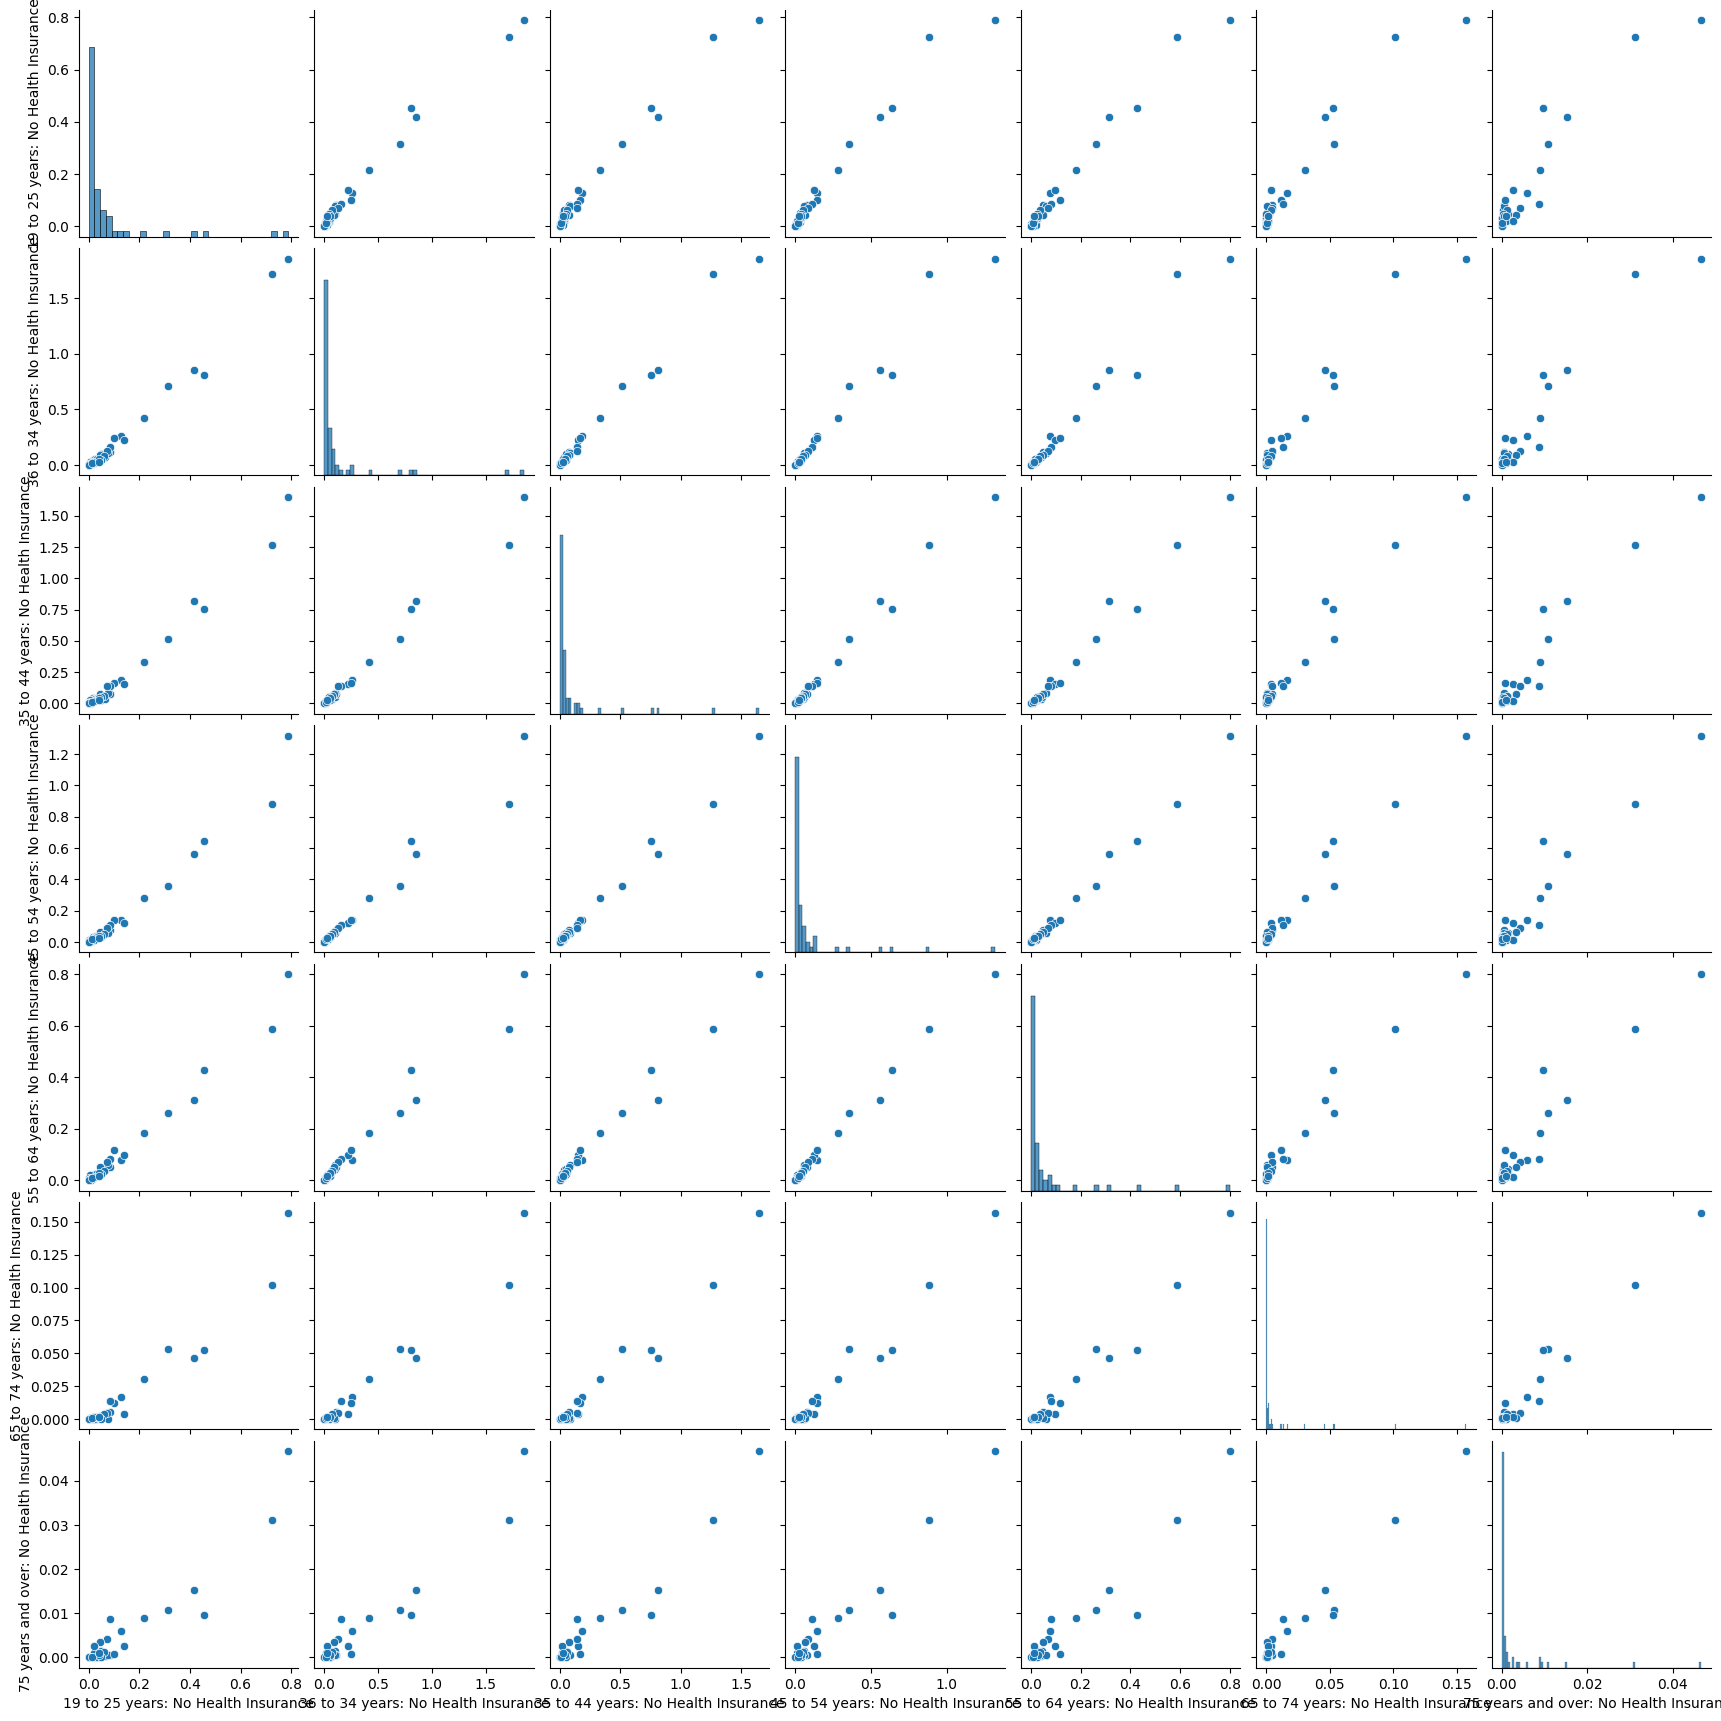

In [112]:
health_votes = health_sums[health_wo].drop(["County"], axis = 1)

health_votes["Votes"] = pres_agg["Votes Per County"]

health_cols3 = list(health_votes.columns.values)
health_cols3.remove("Votes")

# divide education counts by vote per county
# should give percent of community included in voting data
health_votes = health_votes[health_cols3].div(health_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(health_votes)

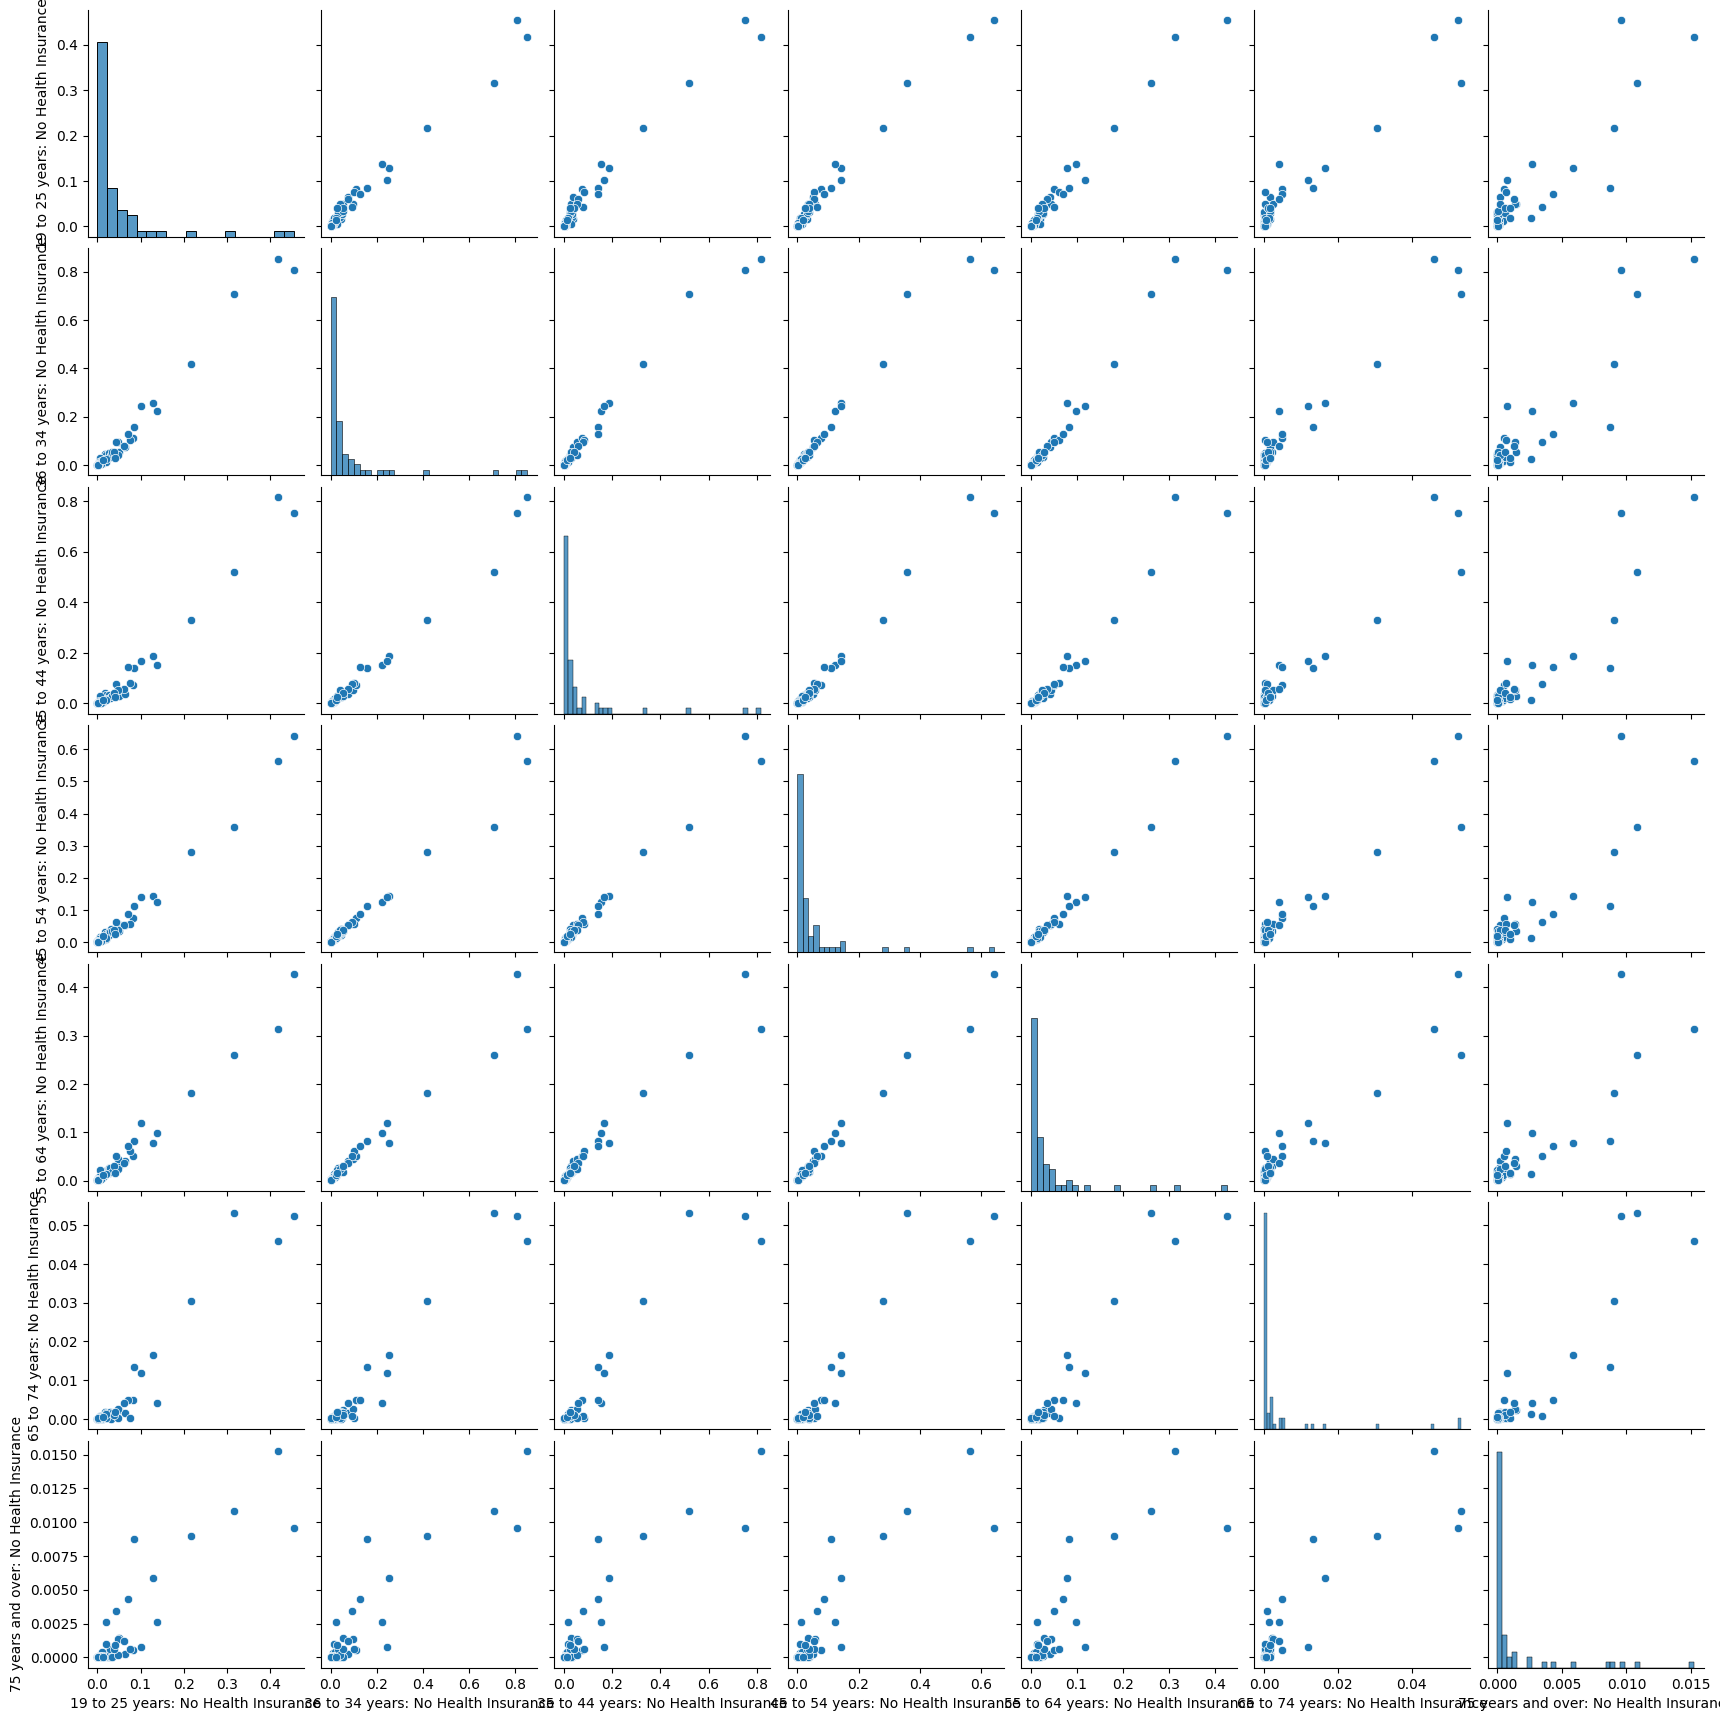

In [114]:
# remove values over 100%
for i in health_cols3:
    health_votes = health_votes.loc[health_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(health_votes)

### Income

In [121]:
# THIS ISN'T RIGHT

In [118]:
# to be useable for pairplot, sum for each type of work type
income = [incomeDF["County"],
          incomeDF["Total Male: Full-Time, Year-Round (dollars)"] + \
          incomeDF["Total Female: Full-Time, Year-Round (dollars)"], 
          incomeDF["Total Male: Other (dollars)"] + \
          incomeDF["Total Female: Other (dollars)"]]

income_sums = pd.DataFrame(income).T.set_axis(["County",
                                               "Full-Time, Year-Round",
                                               "Other"], axis = 1) 

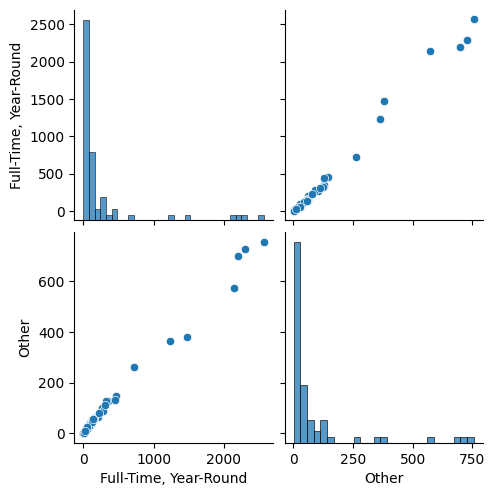

In [120]:
# merge income_sums with votes per county
income_votes = income_sums.drop(["County"], axis = 1)

# get income columns
income_cols = list(income_votes.columns.values)

income_votes["Votes"] = pres_agg["Votes Per County"]


# divide education counts by vote per county
# should give percent of community included in voting data
income_votes = income_votes[income_cols].div(income_votes["Votes"], axis = 0)



# # pairplot to visualize
# sns.pairplot(income_votes)

### Housing

#### Housing, Female

In [122]:
# sum female only
fHousing = [housingDF["County"],
            housingDF["Total: Female householder, no spouse or partner present:"],
            housingDF["Total: Female householder, no spouse or partner present: Living alone"],
            housingDF["Total: Female householder, no spouse or partner present: With only nonrelatives present"],
            housingDF["Total: Female householder, no spouse or partner present: With own children under 18 years"],
            housingDF["Total: Female householder, no spouse or partner present: With relatives, no own children under 18 years"]]

fHousing_sums = pd.DataFrame(fHousing).T.set_axis(["County",
                                                   "No Spouse or Partner",
                                                   "Living Alone",
                                                   "With Only Nonrelatives",
                                                   "With Own Children Under 18",
                                                   "With Relatives, No Children"], axis = 1)

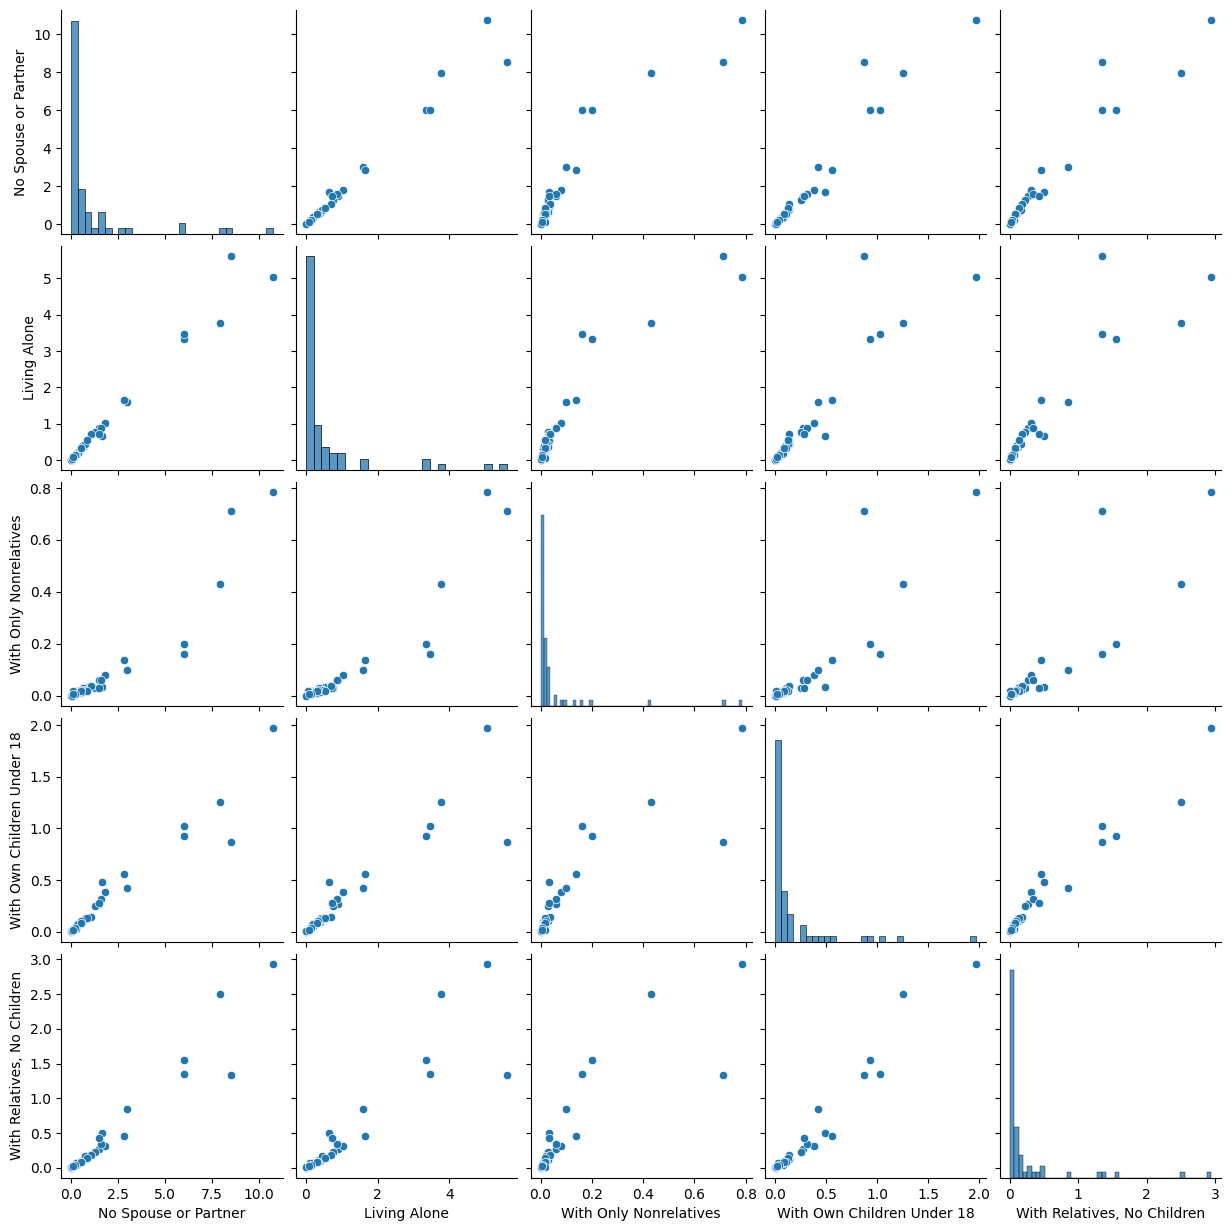

In [123]:
# merge fHousing_sums with votes per county

female_votes = fHousing_sums.drop(["County"], axis = 1)

# get education columns
female_cols = list(female_votes.columns.values)

female_votes["Votes"] = pres_agg["Votes Per County"]


# divide female counts by vote per county
# should give percent of community included in voting data
female_votes = female_votes[female_cols].div(female_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(female_votes)

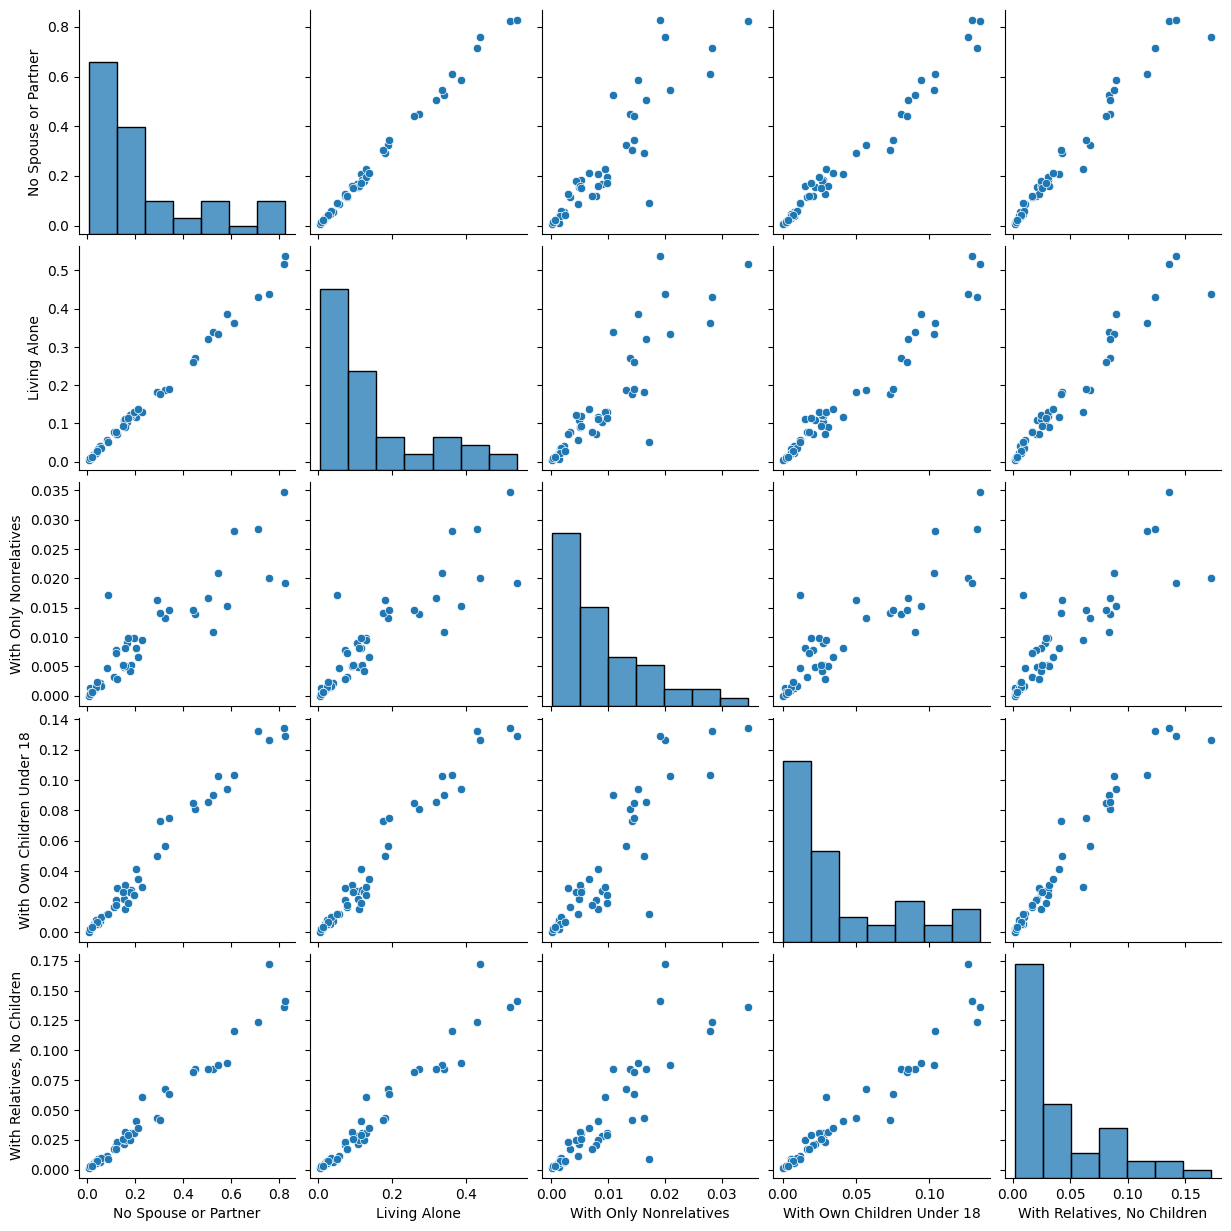

In [124]:
# remove values over 100%
for i in female_cols:
    female_votes = female_votes.loc[female_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(female_votes)

#### Housing, Male

In [125]:
# sum male only
mHousing = [housingDF["County"],
            housingDF["Total: Male householder, no spouse or partner present:"],
            housingDF["Total: Male householder, no spouse or partner present: Living alone"],
            housingDF["Total: Male householder, no spouse or partner present: With only nonrelatives present"],
            housingDF["Total: Male householder, no spouse or partner present: With own children under 18 years"],
            housingDF["Total: Male householder, no spouse or partner present: With relatives, no own children under 18 years"]]

mHousing_sums = pd.DataFrame(mHousing).T.set_axis(["County",
                                                   "No Spouse or Partner",
                                                   "Living Alone",
                                                   "With Only Nonrelatives",
                                                   "With Own Children Under 18",
                                                   "With Relatives, No Children"], axis = 1)

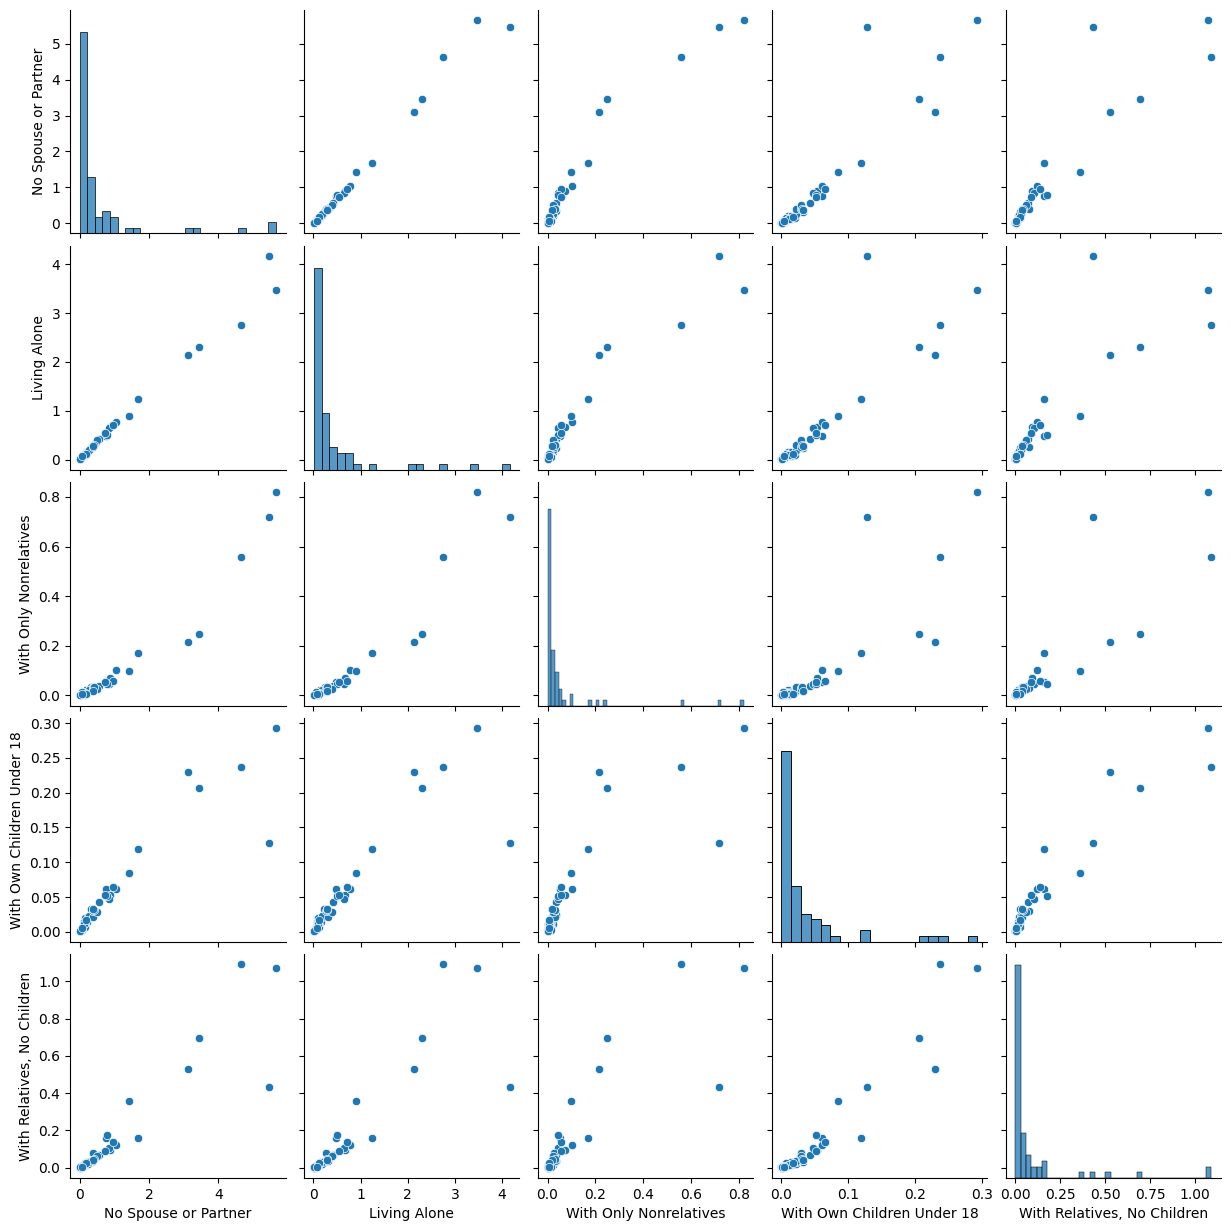

In [129]:
# merge mHousing_sums with votes per county

male_votes = mHousing_sums.drop(["County"], axis = 1)

# get male columns
male_cols = list(male_votes.columns.values)

male_votes["Votes"] = pres_agg["Votes Per County"]


# divide male counts by vote per county
# should give percent of community included in voting data
male_votes = male_votes[male_cols].div(male_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(male_votes)

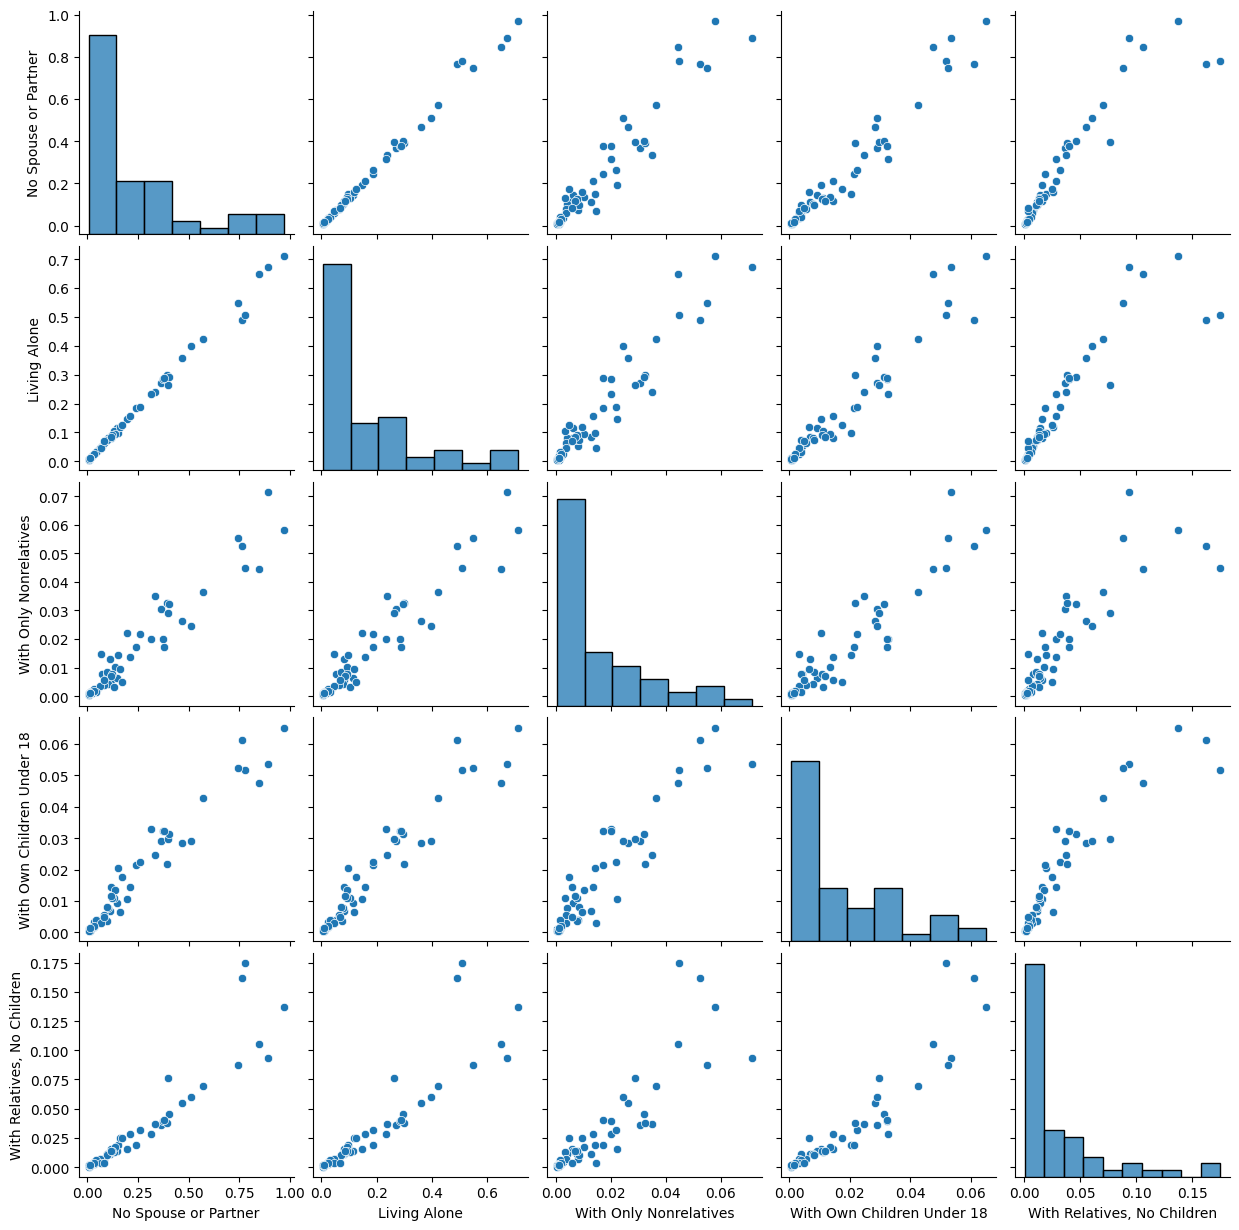

In [130]:
# remove values over 100%
for i in male_cols:
    male_votes = male_votes.loc[male_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(male_votes)

#### Housing, Cohabiting and Married

In [134]:
# sum male only
c_mHousing = [housingDF["County"],
              housingDF["Total: Married-couple household: With own children under 18 years"],
              housingDF["Total: Married-couple household: With no own children under 18 years"],
              housingDF["Total: Cohabiting couple household: With own children of the householder under 18 years"],
              housingDF["Total: Cohabiting couple household: With no own children of the householder under 18 years"]]

c_mHousing_sums = pd.DataFrame(c_mHousing).T.set_axis(["County",
                                                     "Married: With Children Under 18",
                                                     "Married: No Children Under 18",
                                                     "Cohabiting Couple: With Children Under 18",
                                                     "Cohabiting Couple: No Children Under 18"], axis = 1)

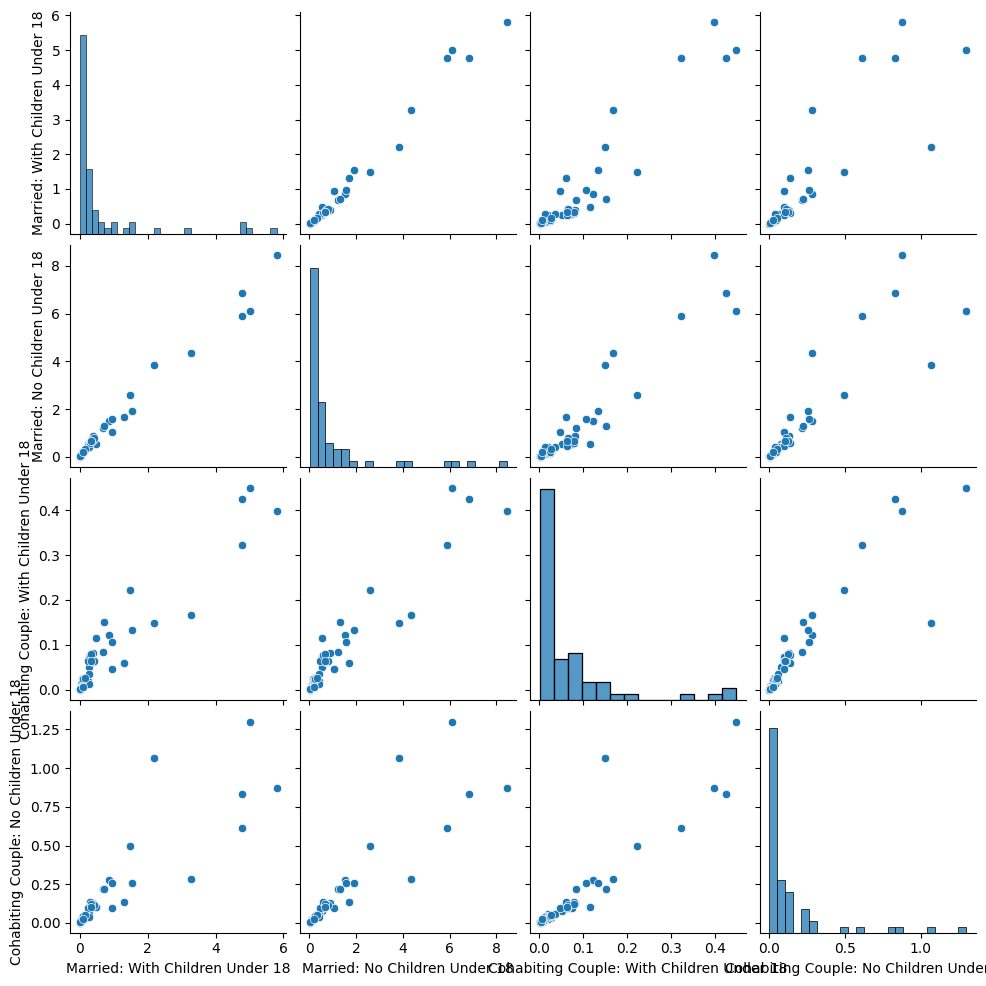

In [135]:
# merge c_mHousing_sums with votes per county

cm_votes = c_mHousing_sums.drop(["County"], axis = 1)

# get male columns
cm_cols = list(cm_votes.columns.values)

cm_votes["Votes"] = pres_agg["Votes Per County"]


# divide male counts by vote per county
# should give percent of community included in voting data
cm_votes = cm_votes[cm_cols].div(cm_votes["Votes"], axis = 0)

# pairplot to visualize
sns.pairplot(cm_votes)

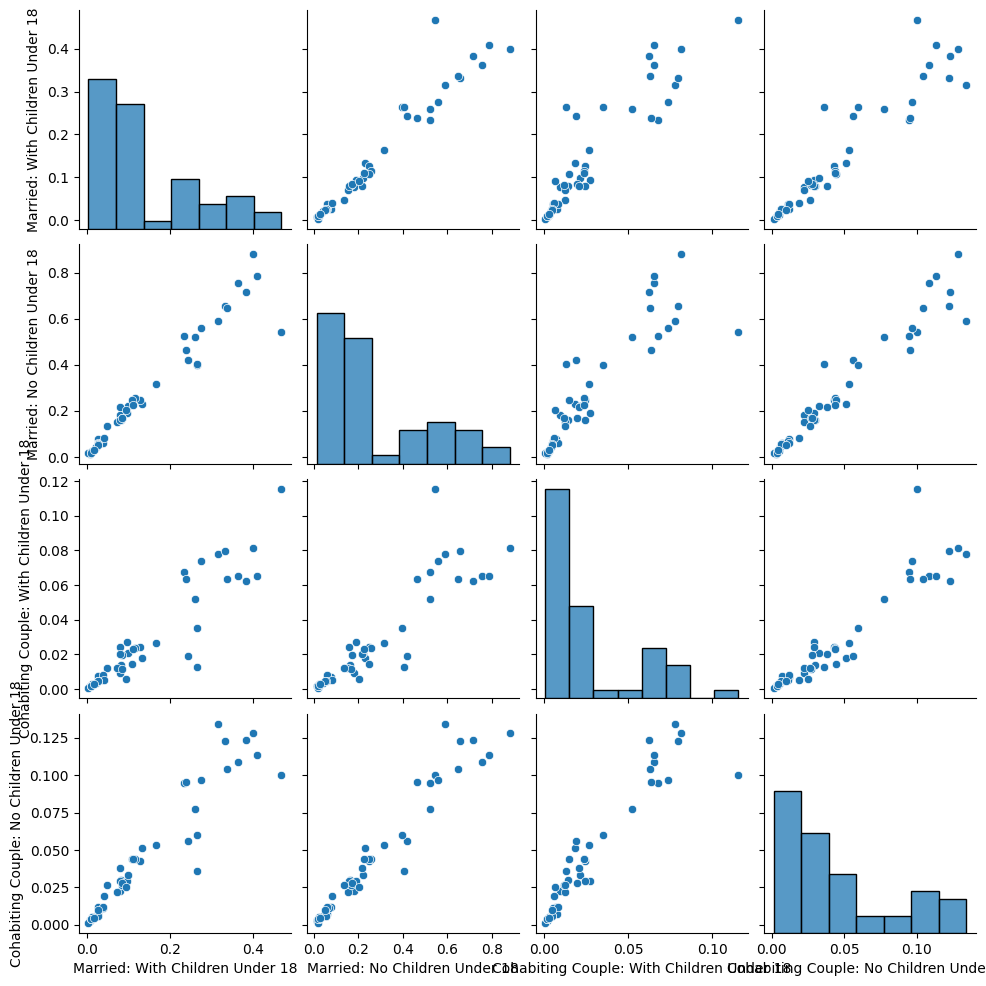

In [136]:
# remove values over 100%
for i in cm_cols:
    cm_votes = cm_votes.loc[cm_votes[i] <= 1]
    
# removing over 100% values, shows many less data points
# and show more variablity 
sns.pairplot(cm_votes)